In [56]:
import random
import cv2
import os
from skimage import io, transform
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score

In [57]:
dataset = []

In [58]:
def load_images_from_folder(folder, label):
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized_img = transform.resize(gray_img, (100,100), mode='symmetric',preserve_range=True)
            dataset.append((resized_img, label))

In [59]:
for folderName in tqdm(os.listdir("words")):
    load_images_from_folder("words/"+folderName, folderName)

100%|██████████| 125/125 [27:11<00:00, 13.06s/it]


In [60]:
random.shuffle(dataset)

In [61]:
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

In [62]:
# Extract images and labels from train and test data
X_train = np.array([item[0] for item in train_data])
y_train = np.array([item[1] for item in train_data])
X_test = np.array([item[0] for item in test_data])
y_test = np.array([item[1] for item in test_data])

In [63]:
# Convert string labels to integer indices
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [64]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(126, activation='softmax')
])

In [65]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [66]:
# Train the model
history = model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_test, y_test_encoded))

Epoch 1/10
1562/1562 [==============================] - 4320s 3s/step - loss: 1.6477 - accuracy: 0.6471 - val_loss: 0.5804 - val_accuracy: 0.8389
Epoch 2/10
1562/1562 [==============================] - 4484s 3s/step - loss: 0.4101 - accuracy: 0.8840 - val_loss: 0.3881 - val_accuracy: 0.8879
Epoch 3/10
1562/1562 [==============================] - 4473s 3s/step - loss: 0.2157 - accuracy: 0.9366 - val_loss: 0.3862 - val_accuracy: 0.8937
Epoch 4/10
1562/1562 [==============================] - 4341s 3s/step - loss: 0.1448 - accuracy: 0.9547 - val_loss: 0.3432 - val_accuracy: 0.9123
Epoch 5/10
1562/1562 [==============================] - 4344s 3s/step - loss: 0.1092 - accuracy: 0.9657 - val_loss: 0.4008 - val_accuracy: 0.9039
Epoch 6/10
1562/1562 [==============================] - 4336s 3s/step - loss: 0.0935 - accuracy: 0.9698 - val_loss: 0.4675 - val_accuracy: 0.8963
Epoch 7/10
1562/1562 [==============================] - 4339s 3s/step - loss: 0.0751 - accuracy: 0.9770 - val_loss: 0.3613 -

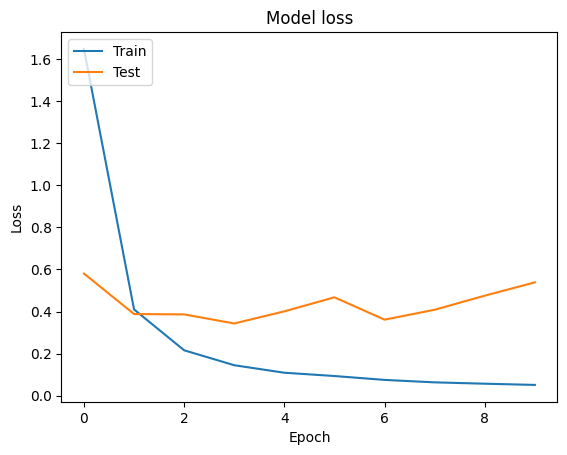

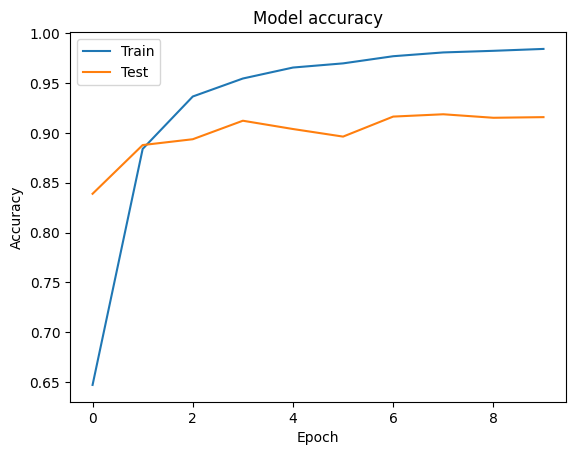

In [67]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [68]:
model.save("mdoel2_epoch10_batch32")

INFO:tensorflow:Assets written to: mdoel2_epoch10_batch32\assets


INFO:tensorflow:Assets written to: mdoel2_epoch10_batch32\assets


In [69]:
# Load the saved model
model = load_model("mdoel2_epoch10_batch32")

In [70]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print("Test Accuracy:", test_accuracy)

391/391 [==============================] - 294s 750ms/step - loss: 0.5385 - accuracy: 0.9159
Test Accuracy: 0.9158728718757629


In [72]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (100, 100))
    img = np.expand_dims(img, axis=-1)
    return img

In [73]:
def predict_label(image_path):
    img = preprocess_image(image_path)
    predictions = model.predict(np.array([img]))
    
    sorted = np.argsort(predictions, axis=1)
    sorted = np.flip(sorted, axis=1)
    sorted_probabilities = np.take_along_axis(predictions, sorted, axis=1)
    sorted_predicted_classes = sorted[:, :10] 
    sorted_predicted_labels = []
    for the_class in sorted_predicted_classes:
        sorted_predicted_label = label_encoder.inverse_transform(the_class)
        sorted_predicted_labels.append(sorted_predicted_label)
    print(sorted_predicted_labels)
    
    predicted_class_idx = np.argmax(predictions)
    predicted_label = label_encoder.inverse_transform([predicted_class_idx])[0]
    plt.imshow(img, cmap='gray')
    plt.title(label=predicted_label)
    plt.show()
    return predicted_label

In [74]:
def load_test_images_from_folder(folder):
    test_data = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized_img = transform.resize(gray_img, (100,100), mode='symmetric',preserve_range=True)
            test_data.append((resized_img, filename.split(".")[0]))
    return test_data

In [75]:
final_test_data = load_test_images_from_folder("test_dataset")
test_images = np.array([item[0] for item in final_test_data])
test_labels = np.array([item[1] for item in final_test_data])
test_labels_encoded = label_encoder.transform(test_labels)
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_images, test_labels_encoded)
print("Test Accuracy:", test_accuracy)

4/4 [==============================] - 3s 730ms/step - loss: 3.3528 - accuracy: 0.5840
Test Accuracy: 0.5839999914169312


1/1 [==============================] - 0s 113ms/step
[array(['EIGHTEENTH', 'SEVENTEENTH', 'MYSELF', 'THIRTEENTH', 'MOHARRAM',
       'SHABAN', 'FOURTY', 'MIN', 'FOURTEENTH', 'HEJRY'], dtype='<U14')]


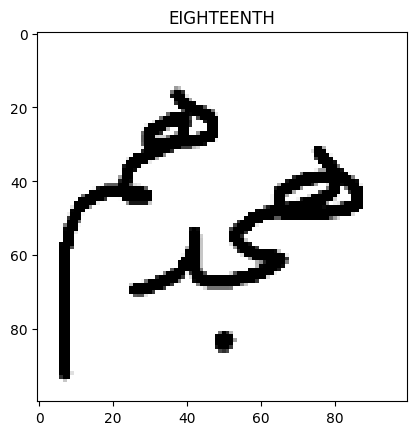

In [76]:
predicted_label = predict_label(os.path.join("test_dataset","EIGHTEENTH.png"))

1/1 [==============================] - 0s 64ms/step
[array(['ABAN', 'ONEMILLION', 'MACHINE', 'REGARD', 'OFFICE', 'ONE',
       'RAJAB', 'BANK', 'AUTOMOBILE', 'SIR'], dtype='<U14')]


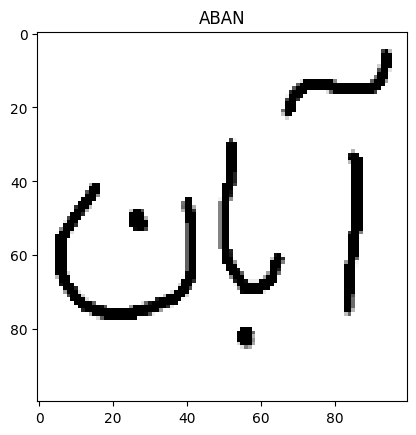

1/1 [==============================] - 0s 83ms/step
[array(['ACOLYTE', 'FARVARDIN', 'CORPORATION', 'NINETEEN', 'SIXTY',
       'TOMAN', 'FA_MAX', 'SEVENTY', 'HOME', 'FOURTY'], dtype='<U14')]


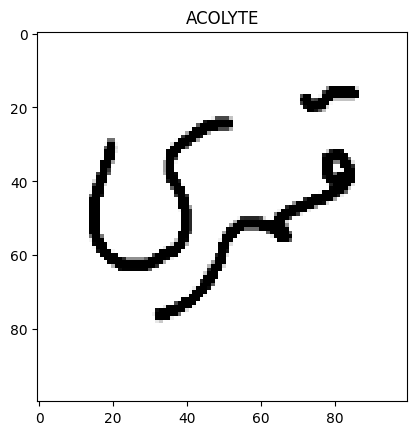

1/1 [==============================] - 0s 81ms/step
[array(['NINETY', 'MEHR', 'TWO', 'NINTH', 'THREEHUNDRED', 'FIVE', 'THIRD',
       'THIRTY', 'THREE', 'INITIAL'], dtype='<U14')]


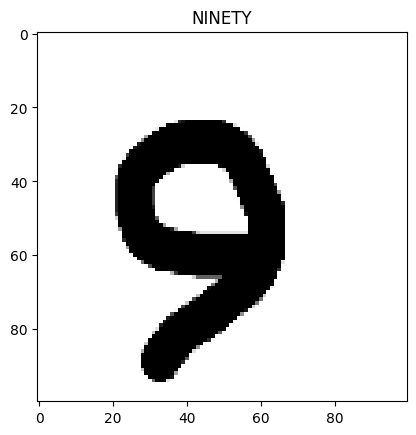

1/1 [==============================] - 0s 74ms/step
[array(['AUTOMOBILE', 'MOBILE', 'FARVARDIN', 'ORDIBEHESHT', 'INITIAL',
       'ONEMILLION', 'ABAN', 'RABIE_O_SANI', 'THIRTEEN', 'COLLEGE'],
      dtype='<U14')]


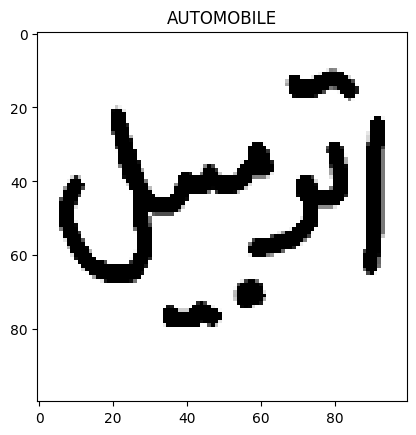

1/1 [==============================] - 0s 64ms/step
[array(['AZAR', 'FOURTEEN', 'OFFICE', 'FOURHUNDRED', 'FOUR', 'HEJRY',
       'MORDAD', 'TWELVE', 'THIRTEEN', 'FOURTEENTH'], dtype='<U14')]


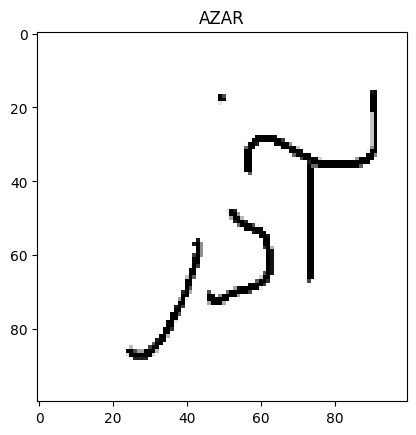

1/1 [==============================] - 0s 64ms/step
[array(['BAHMAN', 'THIRD', 'INITIAL', 'REGARD', 'FOURTH', 'MOHARRAM',
       'TWENTY', 'THIRTY', 'TWENTIETH', 'FOURTEENTH'], dtype='<U14')]


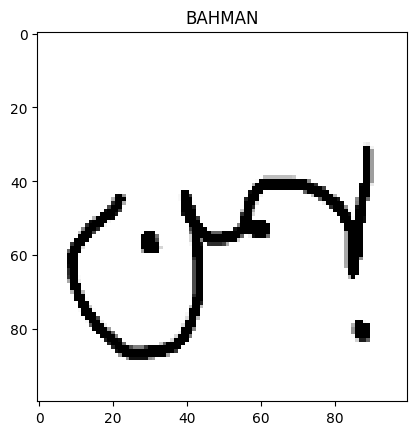

1/1 [==============================] - 0s 80ms/step
[array(['BANK', 'ONEHUNDRED', 'ONE', 'FIRST', 'RAJAB', 'COLLEGE', 'FOURTH',
       'MAX', 'ABAN', 'END'], dtype='<U14')]


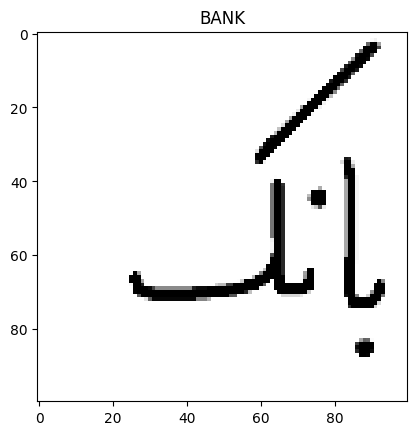

1/1 [==============================] - 0s 82ms/step
[array(['SIXTEENTH', 'JAMADI_OL_AVAL', 'COMPUTER', 'EQUIVALENT',
       'MOHARRAM', 'MAX', 'THIRTY', 'SHAHRIVAR', 'ELEVEN', 'MACHINE'],
      dtype='<U14')]


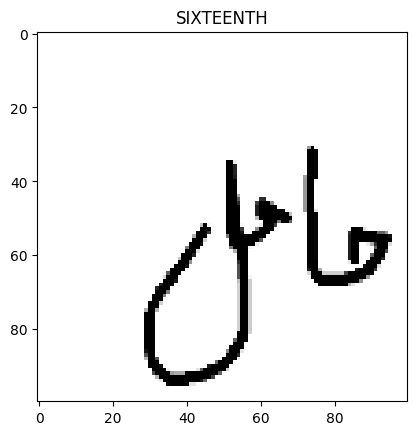

1/1 [==============================] - 0s 78ms/step
[array(['COLLEGE', 'ZEI_HAJJE', 'RABIE_O_SANI', 'EIGHTHUNDRED',
       'FIVEHUNDRED', 'ORDIBEHESHT', 'ZEI_GHADE', 'FIFTEENTH', 'MACHINE',
       'ESFAND'], dtype='<U14')]


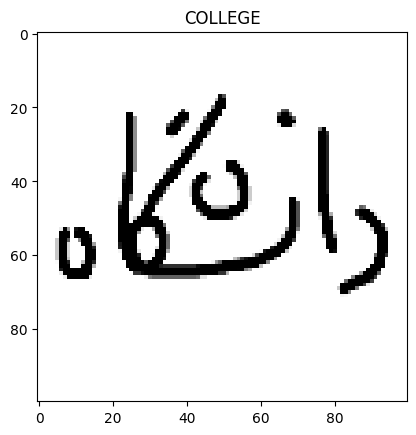

1/1 [==============================] - 0s 82ms/step
[array(['COMPUTER', 'ONEMILLION', 'FARVARDIN', 'FA_MAX', 'MILLION',
       'MACHINE', 'REGARD', 'ONEMILLIARD', 'EIGHTEEN', 'FOURTEEN'],
      dtype='<U14')]


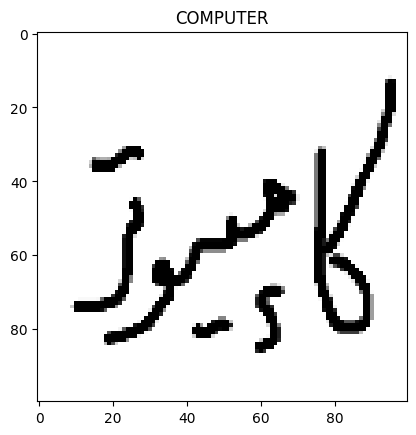

1/1 [==============================] - 0s 84ms/step
[array(['MAX', 'SIXTEENTH', 'SIXTH', 'FIFTEENTH', 'SHABAN', 'MACHINE',
       'FIFTEEN', 'THOUSANDTH', 'ABAN', 'SHAVAL'], dtype='<U14')]


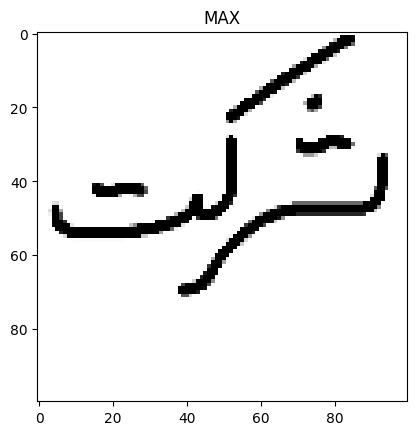

1/1 [==============================] - 0s 84ms/step
[array(['THIRTIETH', 'DEI', 'FIFTY', 'JAMADI_OL_AVAL', 'COLLEGE',
       'ONEMILLIARD', 'END', 'SHABAN', 'ZEI_HAJJE', 'FOURTH'],
      dtype='<U14')]


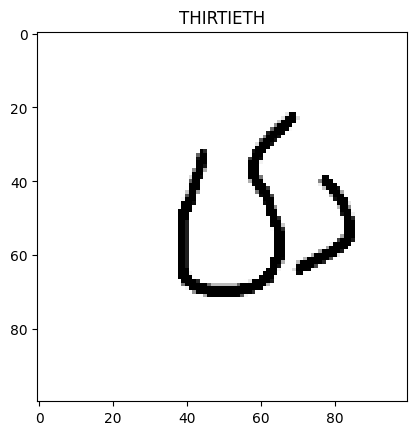

1/1 [==============================] - 0s 90ms/step
[array(['EIGHTH', 'SEVENTH', 'SEVEN', 'REGARD', 'GENTLEMAN', 'TWENTY',
       'MACHINE', 'SEVENTEENTH', 'BAHMAN', 'SEVENHUNDRED'], dtype='<U14')]


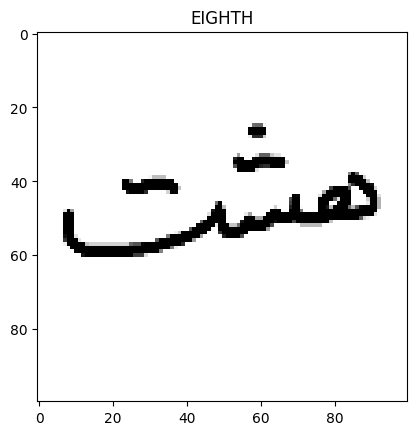

1/1 [==============================] - 0s 84ms/step
[array(['EIGHTEENTH', 'EIGHTEEN', 'FOURTH', 'FOURTEENTH', 'COMPUTER',
       'FIFTH', 'MIN', 'FARVARDIN', 'FA_MAX', 'ONEMILLION'], dtype='<U14')]


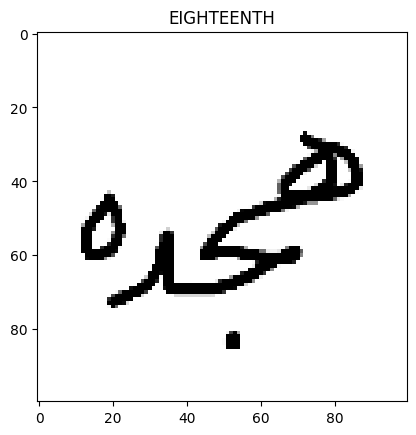

1/1 [==============================] - 0s 84ms/step
[array(['SEVENTH', 'EIGHTH', 'NINTH', 'EIGHTY', 'SIXTH', 'SEVENTY', 'SIX',
       'GENTLEMAN', 'MEHR', 'END'], dtype='<U14')]


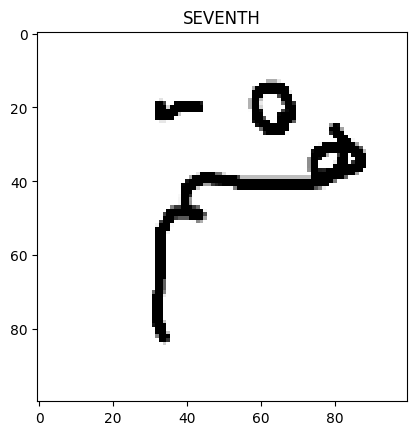

1/1 [==============================] - 0s 60ms/step
[array(['EIGHTHUNDRED', 'SEVENHUNDRED', 'ONEHUNDRED', 'EIGHTY',
       'FIVEHUNDRED', 'EIGHT', 'SEVEN', 'COLLEGE', 'NINEHUNDRED',
       'EIGHTH'], dtype='<U14')]


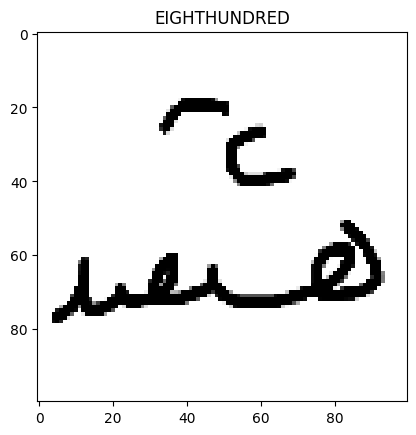

1/1 [==============================] - 0s 60ms/step
[array(['EIGHTY', 'EIGHT', 'FIFTY', 'EIGHTH', 'EIGHTHUNDRED', 'SELVES',
       'FIFTEEN', 'SEVENTY', 'KHORDAD', 'SEVENTEEN'], dtype='<U14')]


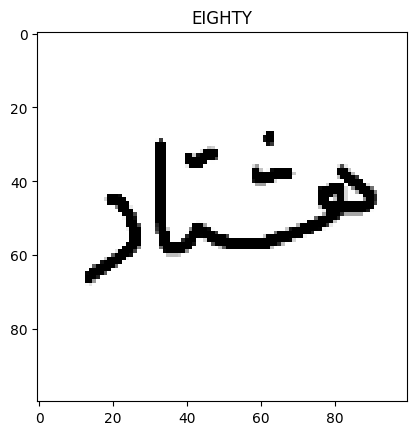

1/1 [==============================] - 0s 63ms/step
[array(['MAX', 'ELEVENTH', 'FIFTEENTH', 'COLLEGE', 'ELEVEN', 'NINETEENTH',
       'FOURTEENTH', 'INSTITUTION', 'JAMADI_OL_AVAL', 'FIFTEEN'],
      dtype='<U14')]


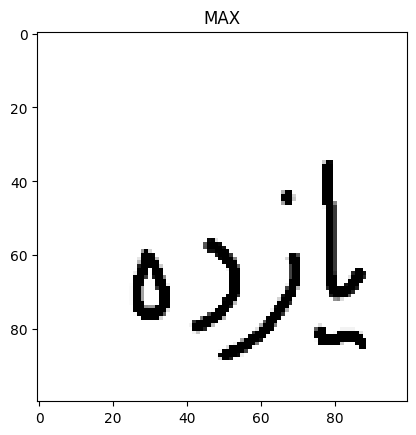

1/1 [==============================] - 0s 65ms/step
[array(['ELEVENTH', 'FA_MAX', 'NINETEENTH', 'FIFTEENTH', 'FA_MIN',
       'FOURTEENTH', 'REGARD', 'MAX', 'TWELFTH', 'SIXTEENTH'],
      dtype='<U14')]


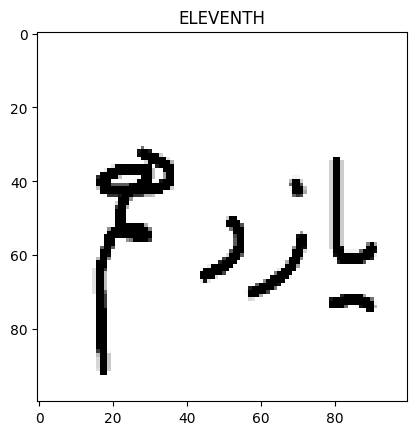

1/1 [==============================] - 0s 67ms/step
[array(['SHABAN', 'END', 'FOUR', 'SOLAR', 'TOMAN', 'EXCELLENCY', 'SHAVAL',
       'FOURTH', 'ONEMILLIARD', 'RAMEZAN'], dtype='<U14')]


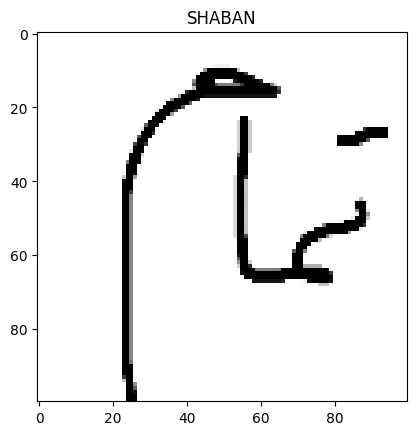

1/1 [==============================] - 0s 68ms/step
[array(['EQUIVALENT', 'SHAVAL', 'SHABAN', 'MOBILE', 'HOME', 'THIRTIETH',
       'INITIAL', 'HEJRY', 'FA_MIN', 'KHORDAD'], dtype='<U14')]


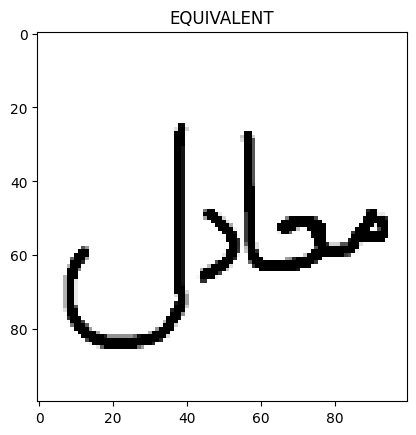

1/1 [==============================] - 0s 65ms/step
[array(['FIVEHUNDRED', 'FIFTEEN', 'ESFAND', 'ONETHOUSAND', 'AZAR', 'TEL',
       'FIFTEENTH', 'MACHINE', 'ORDIBEHESHT', 'SEVENHUNDRED'],
      dtype='<U14')]


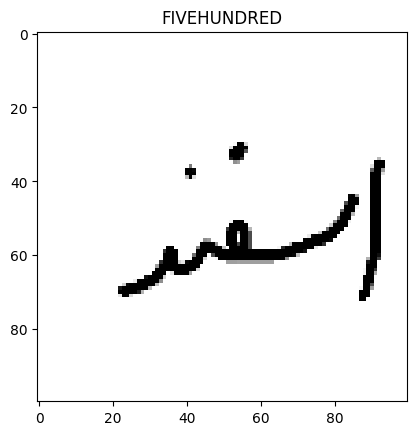

1/1 [==============================] - 0s 64ms/step
[array(['EXCELLENCY', 'FOUR', 'FOURTH', 'FIFTY', 'FOURTEENTH',
       'RABIE_O_SANI', 'FOURHUNDRED', 'SHABAN', 'ZEI_HAJJE', 'RIAL'],
      dtype='<U14')]


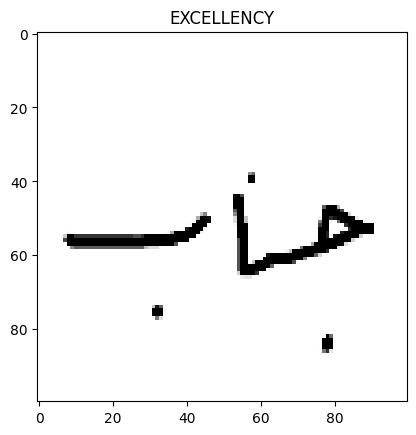

1/1 [==============================] - 0s 84ms/step
[array(['FARVARDIN', 'AUTOMOBILE', 'THIRTEEN', 'HEJRY', 'COMPUTER',
       'SHAHRIVAR', 'MILLION', 'NINETEEN', 'FOURTEENTH', 'FOURTEEN'],
      dtype='<U14')]


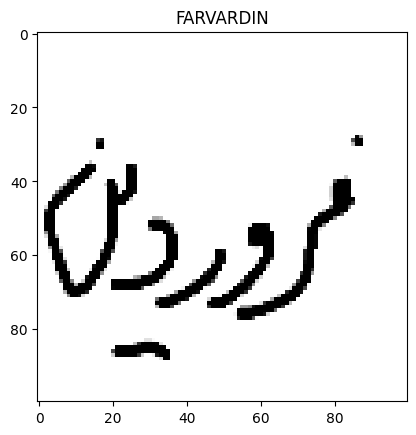

1/1 [==============================] - 0s 65ms/step
[array(['FA_COMPUTER', 'OFFICE', 'MILLIARD', 'MILLION', 'COMPUTER',
       'ORDIBEHESHT', 'FARVARDIN', 'ONEMILLION', 'FOURTEEN', 'MOBILE'],
      dtype='<U14')]


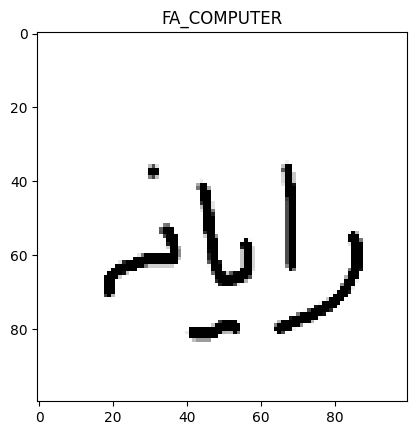

1/1 [==============================] - 0s 57ms/step
[array(['FA_MAX', 'OVERSEER', 'FIFTH', 'ACOLYTE', 'CORPORATION', 'EIGHT',
       'EIGHTY', 'EIGHTHUNDRED', 'FIVE', 'THOUSANDTH'], dtype='<U14')]


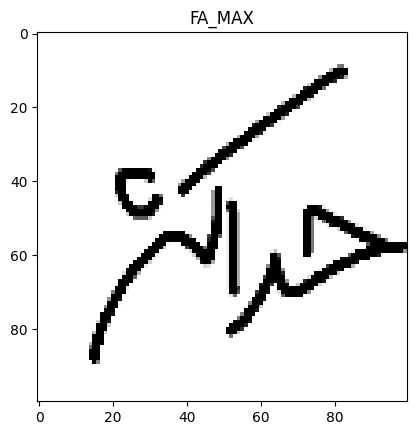

1/1 [==============================] - 0s 78ms/step
[array(['FA_MIN', 'OVERSEER', 'FA_MAX', 'KHORDAD', 'MILLION', 'SELVES',
       'HEJRY', 'BEARER', 'JAMADI_OL_AVAL', 'SHAVAL'], dtype='<U14')]


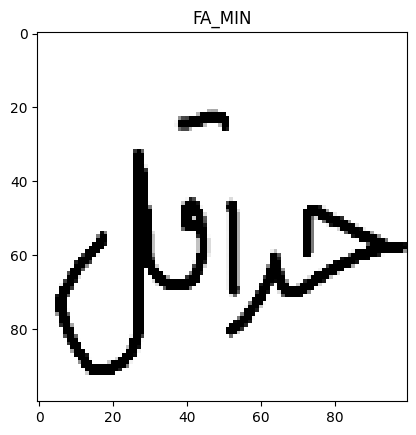

1/1 [==============================] - 0s 76ms/step
[array(['NINETEENTH', 'ELEVENTH', 'FOURTEENTH', 'COLLEGE', 'SELVES',
       'INSTITUTION', 'FIFTEENTH', 'TWELFTH', 'FIVEHUNDRED', 'FA_MAX'],
      dtype='<U14')]


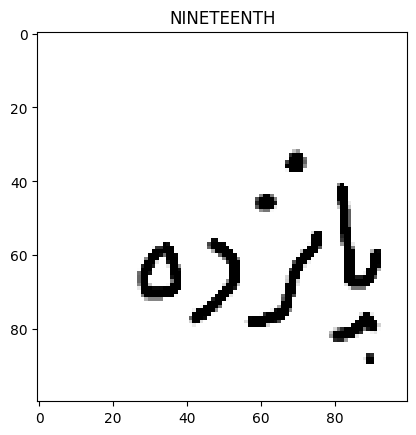

1/1 [==============================] - 0s 62ms/step
[array(['MAX', 'NINETEENTH', 'ZEI_HAJJE', 'BANK', 'SEVENTEENTH', 'FA_MAX',
       'ELEVENTH', 'COLLEGE', 'FOURTEENTH', 'NINTH'], dtype='<U14')]


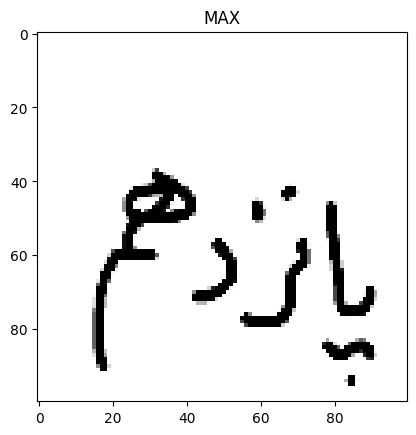

1/1 [==============================] - 0s 64ms/step
[array(['FIFTH', 'ORDIBEHESHT', 'NINTH', 'COLLEGE', 'FIVE', 'ZEI_HAJJE',
       'AUTOMOBILE', 'ZERO', 'SELVES', 'FA_MIN'], dtype='<U14')]


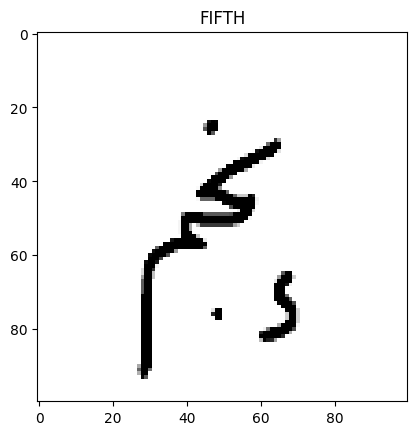

1/1 [==============================] - 0s 75ms/step
[array(['FIFTY', 'SHABAN', 'EXCELLENCY', 'FOURTH', 'RAJAB', 'EIGHTEENTH',
       'ORDIBEHESHT', 'MIN', 'THIRTIETH', 'FA_COMPUTER'], dtype='<U14')]


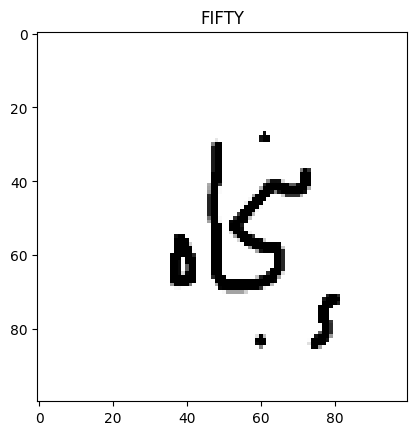

1/1 [==============================] - 0s 73ms/step
[array(['FIRST', 'ACOLYTE', 'FOURTH', 'END', 'ELEVEN', 'ABAN', 'TEL',
       'MILLION', 'MIN', 'ONETHOUSAND'], dtype='<U14')]


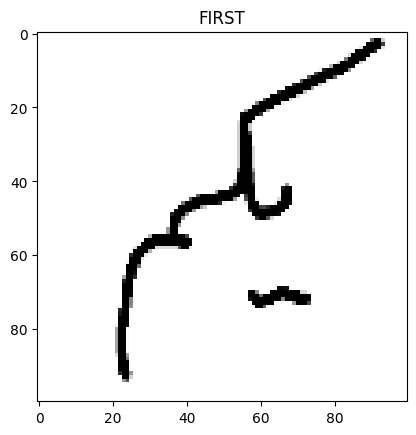

1/1 [==============================] - 0s 88ms/step
[array(['FIFTH', 'AUTOMOBILE', 'FIVE', 'RAJAB', 'COLLEGE', 'MIN', 'FIFTY',
       'DEI', 'THIRTEENTH', 'THIRTEEN'], dtype='<U14')]


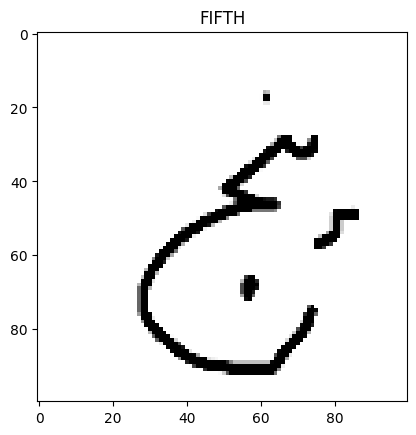

1/1 [==============================] - 0s 67ms/step
[array(['FIVEHUNDRED', 'BANK', 'FIFTEEN', 'COLLEGE', 'ONETHOUSAND', 'MAX',
       'ONEHUNDRED', 'EIGHTHUNDRED', 'MACHINE', 'TEL'], dtype='<U14')]


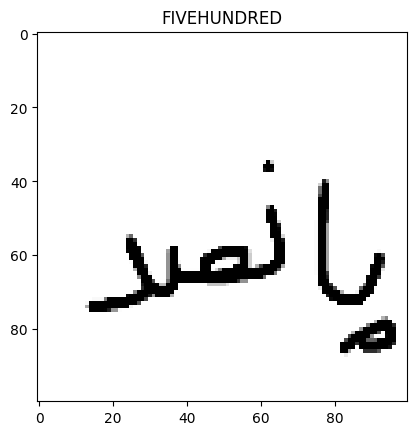

1/1 [==============================] - 0s 83ms/step
[array(['FOURTH', 'TOMAN', 'FOUR', 'RAMEZAN', 'FOURHUNDRED', 'FOURTEENTH',
       'MILLIARD', 'FIVE', 'ONEMILLION', 'SHABAN'], dtype='<U14')]


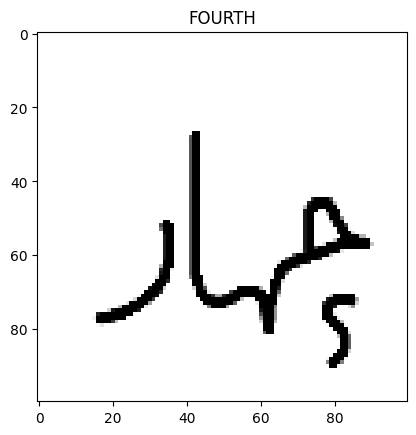

1/1 [==============================] - 0s 88ms/step
[array(['FOURHUNDRED', 'SHAHRIVAR', 'THREEHUNDRED', 'FOURTEENTH',
       'NINEHUNDRED', 'HEJRY', 'FA_MAX', 'KHORDAD', 'BEARER', 'PURCHASE'],
      dtype='<U14')]


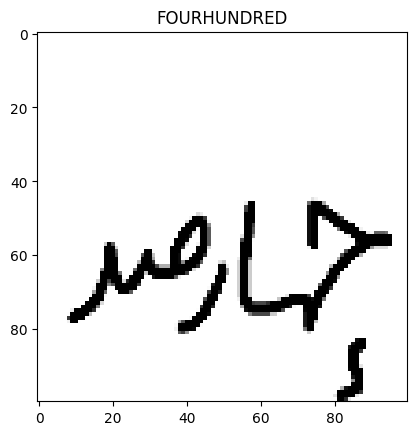

1/1 [==============================] - 0s 63ms/step
[array(['FOURTEENTH', 'FOURTEEN', 'HEJRY', 'EQUIVALENT', 'MOHARRAM',
       'MYSELF', 'EIGHTEEN', 'FARVARDIN', 'SHAHRIVAR', 'KHORDAD'],
      dtype='<U14')]


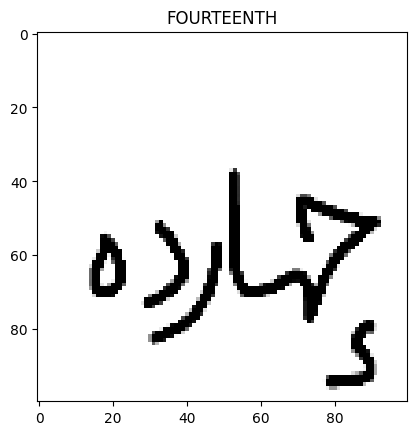

1/1 [==============================] - 0s 69ms/step
[array(['FOURTEENTH', 'SEVENTEENTH', 'FOURTH', 'EIGHTEENTH', 'SECOND',
       'MOHARRAM', 'GENTLEMAN', 'HUNDREDTH', 'FIFTEENTH', 'MYSELF'],
      dtype='<U14')]


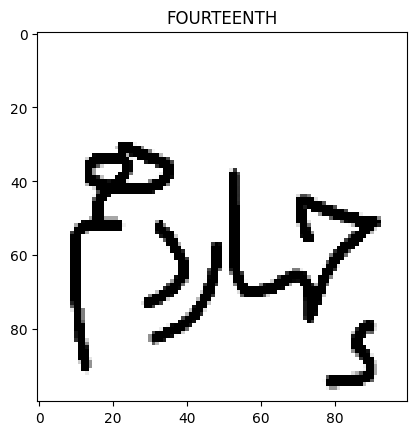

1/1 [==============================] - 0s 63ms/step
[array(['FOURTH', 'THIRTIETH', 'RABIE_O_SANI', 'MOHARRAM', 'FOUR',
       'MYSELF', 'RAMEZAN', 'THOUSANDTH', 'EIGHTEENTH', 'THIRTEENTH'],
      dtype='<U14')]


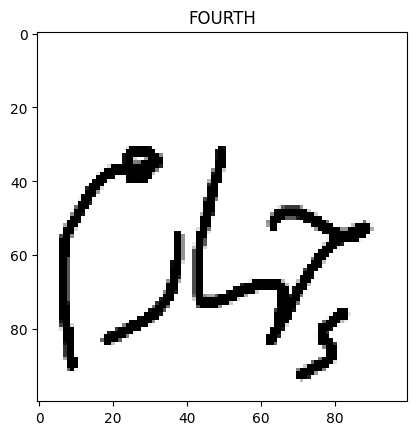

1/1 [==============================] - 0s 72ms/step
[array(['FOURTY', 'FOUR', 'BAHMAN', 'FOURTH', 'INSTITUTION', 'HEJRY',
       'FIVE', 'TOMAN', 'FOURTEENTH', 'AUTOMOBILE'], dtype='<U14')]


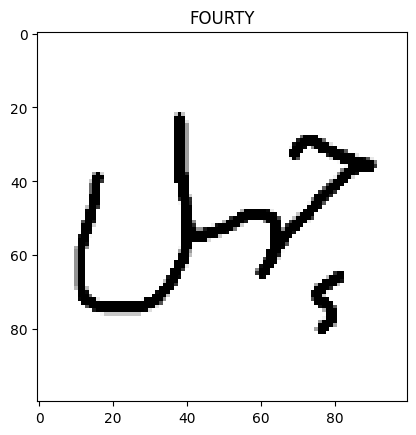

1/1 [==============================] - 0s 64ms/step
[array(['GENTLEMAN', 'SEVENTEENTH', 'NINTH', 'EIGHTEENTH', 'THIRTIETH',
       'HUNDREDTH', 'FIFTEENTH', 'END', 'SEVENTH', 'MOHARRAM'],
      dtype='<U14')]


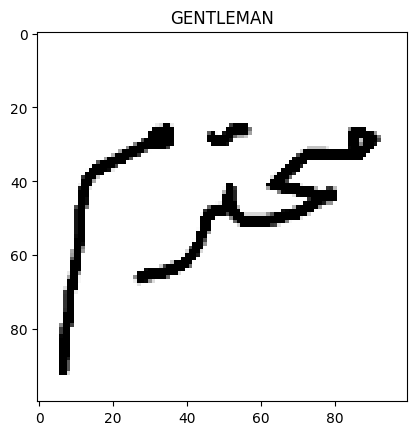

1/1 [==============================] - 0s 85ms/step
[array(['HEJRY', 'MOBILE', 'EIGHTEENTH', 'ONETHOUSAND', 'FOUR', 'BAHMAN',
       'MILLION', 'FOURTEENTH', 'FOURTY', 'KHORDAD'], dtype='<U14')]


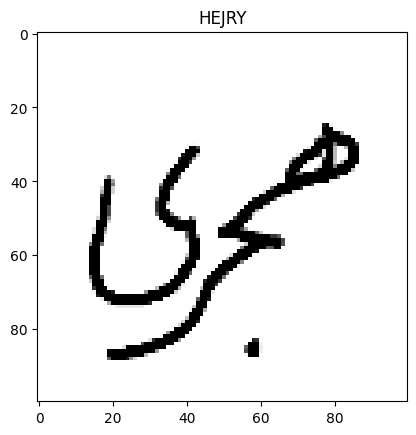

1/1 [==============================] - 0s 62ms/step
[array(['THIRTEENTH', 'MYSELF', 'THOUSANDTH', 'THIRTIETH', 'RABIE_O_SANI',
       'THIRTEEN', 'ELEVEN', 'NINETEENTH', 'SHAVAL', 'EQUIVALENT'],
      dtype='<U14')]


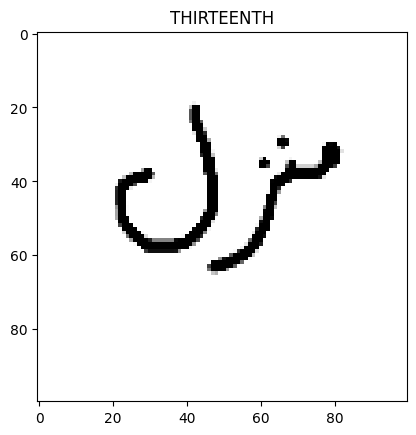

1/1 [==============================] - 0s 89ms/step
[array(['HUNDRED', 'EIGHTEEN', 'MEHR', 'THREEHUNDRED', 'SEVENTEENTH',
       'ZERO', 'ONETHOUSAND', 'THREE', 'TIR', 'FOURHUNDRED'], dtype='<U14')]


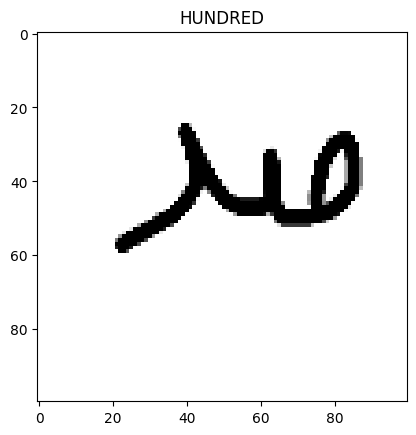

1/1 [==============================] - 0s 99ms/step
[array(['HUNDREDTH', 'GENTLEMAN', 'SEVENTEENTH', 'THIRD', 'THIRTEEN',
       'MYSELF', 'COMPUTER', 'HUNDRED', 'MOHARRAM', 'ZERO'], dtype='<U14')]


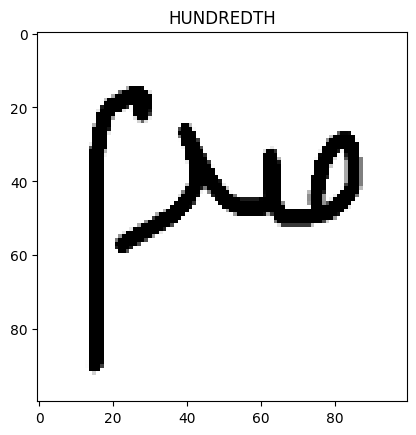

1/1 [==============================] - 0s 71ms/step
[array(['INITIAL', 'MORDAD', 'MOBILE', 'DEI', 'OFFICE', 'SECOND', 'RIAL',
       'TWO', 'EQUIVALENT', 'FOURTY'], dtype='<U14')]


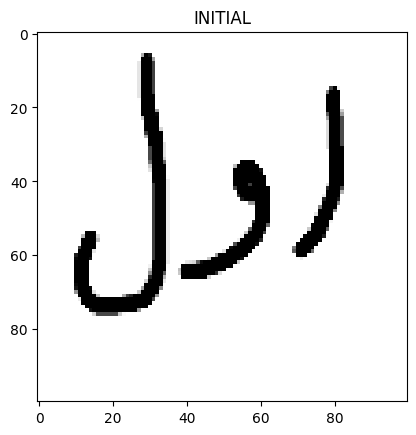

1/1 [==============================] - 0s 78ms/step
[array(['INSTITUTION', 'EIGHTH', 'FARVARDIN', 'PURCHASE', 'EIGHTEEN',
       'EIGHTEENTH', 'NINETEENTH', 'THIRTEEN', 'THOUSANDTH', 'MAX'],
      dtype='<U14')]


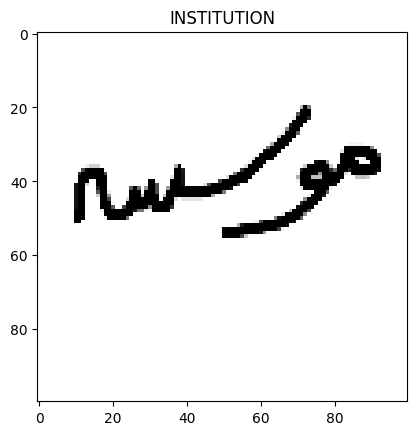

1/1 [==============================] - 0s 73ms/step
[array(['JAMADI_OL_AVAL', 'FOURHUNDRED', 'ONEMILLIARD', 'FOURTH',
       'NINEHUNDRED', 'FOUR', 'INSTITUTION', 'FIFTH', 'FOURTEENTH',
       'ONETHOUSAND'], dtype='<U14')]


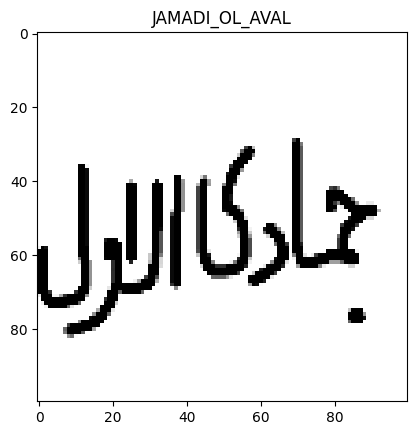

1/1 [==============================] - 0s 86ms/step
[array(['JAMADI_O_SANI', 'RABIE_O_SANI', 'FIVEHUNDRED', 'ORDIBEHESHT',
       'JAMADI_OL_AVAL', 'FARVARDIN', 'RAMEZAN', 'FOURTEENTH', 'SELVES',
       'FOURTH'], dtype='<U14')]


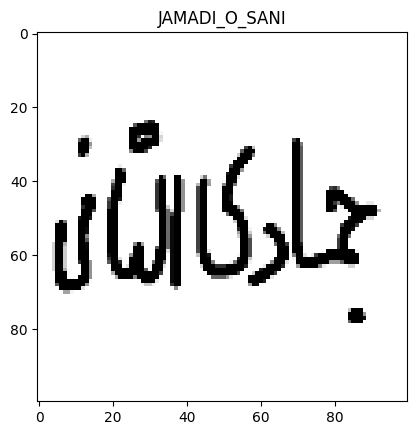

1/1 [==============================] - 0s 59ms/step
[array(['KHORDAD', 'THOUSANDTH', 'FARVARDIN', 'HOME', 'NINETEEN', 'TWELVE',
       'FOURTEEN', 'MYSELF', 'JAMADI_OL_AVAL', 'FA_MIN'], dtype='<U14')]


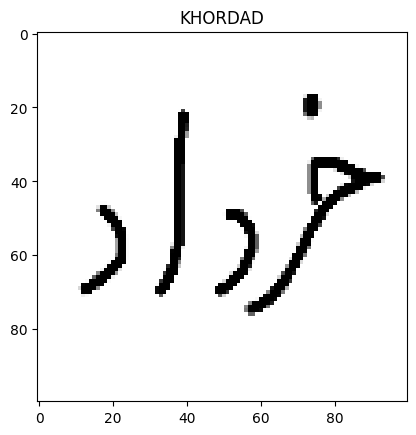

1/1 [==============================] - 0s 65ms/step
[array(['MACHINE', 'REGARD', 'MAX', 'COMPUTER', 'EIGHTH', 'EIGHT',
       'MOBILE', 'ORDIBEHESHT', 'JAMADI_O_SANI', 'FIFTEENTH'],
      dtype='<U14')]


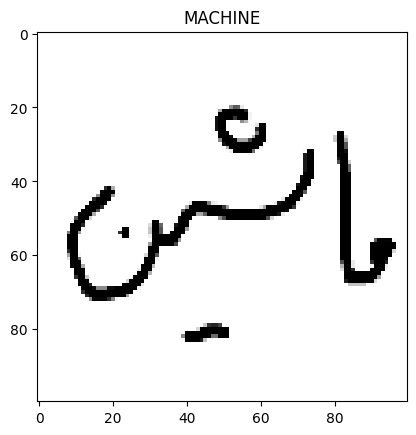

1/1 [==============================] - 0s 89ms/step
[array(['MAX', 'FIFTEENTH', 'AZAR', 'REGARD', 'MACHINE', 'SIXTEENTH',
       'ONETHOUSAND', 'BANK', 'FIFTEEN', 'EIGHTHUNDRED'], dtype='<U14')]


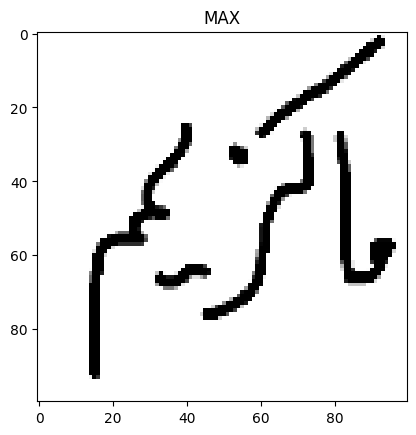

1/1 [==============================] - 0s 79ms/step
[array(['MEHR', 'FOUR', 'BAHMAN', 'NINEHUNDRED', 'HEJRY', 'ZERO',
       'EIGHTEEN', 'FARVARDIN', 'SHAHRIVAR', 'MOHARRAM'], dtype='<U14')]


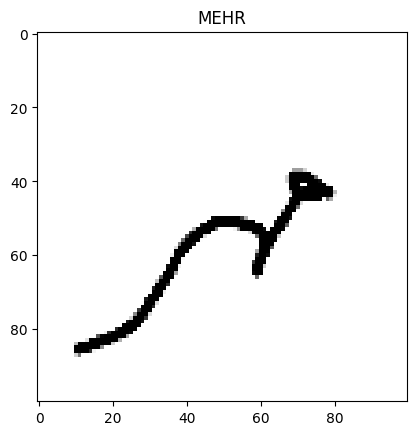

1/1 [==============================] - 0s 85ms/step
[array(['MILLIARD', 'MILLION', 'ONEMILLIARD', 'THIRTEEN', 'FOURTEEN',
       'MORDAD', 'COMPUTER', 'ONEMILLION', 'RABIE_O_SANI', 'ELEVEN'],
      dtype='<U14')]


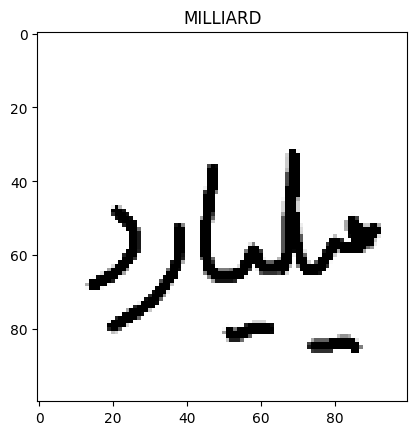

1/1 [==============================] - 0s 62ms/step
[array(['MILLION', 'FARVARDIN', 'ONEMILLION', 'HEJRY', 'RABIE_O_SANI',
       'MOBILE', 'FOURTEENTH', 'FOURTEEN', 'THIRTEEN', 'RABIE_O_AVAL'],
      dtype='<U14')]


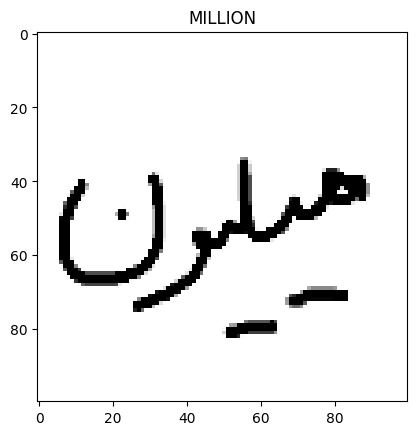

1/1 [==============================] - 0s 58ms/step
[array(['MIN', 'TWENTIETH', 'FIFTH', 'ORDIBEHESHT', 'ESFAND', 'AUTOMOBILE',
       'FIVE', 'SEVENTEENTH', 'FIRST', 'MILLION'], dtype='<U14')]


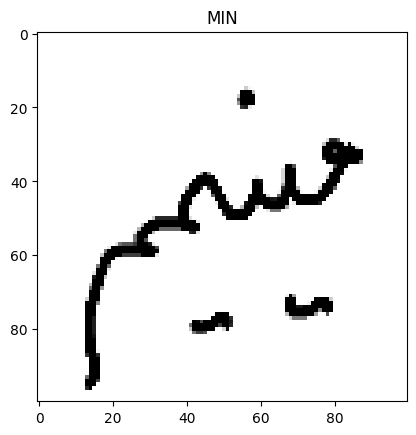

1/1 [==============================] - 0s 73ms/step
[array(['MISTRESS', 'TOMAN', 'EXCELLENCY', 'SIXTEEN', 'TEL', 'ZEI_HAJJE',
       'JAMADI_O_SANI', 'RAMEZAN', 'BEARER', 'END'], dtype='<U14')]


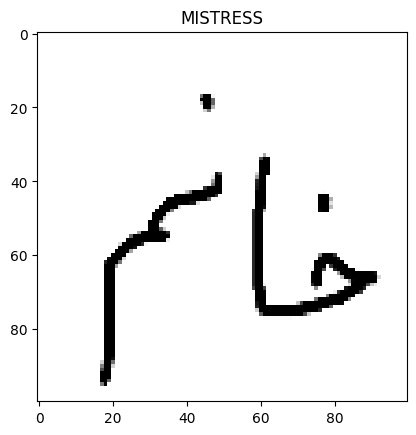

1/1 [==============================] - 0s 84ms/step
[array(['MOBILE', 'SHABAN', 'KHORDAD', 'FARVARDIN', 'ONEMILLIARD',
       'AUTOMOBILE', 'MILLION', 'SHAVAL', 'JAMADI_OL_AVAL', 'SHAHRIVAR'],
      dtype='<U14')]


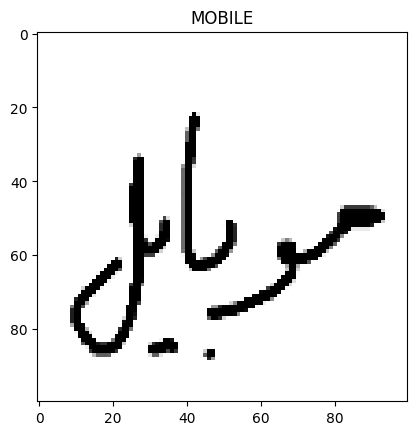

1/1 [==============================] - 0s 65ms/step
[array(['MOHARRAM', 'GENTLEMAN', 'MYSELF', 'BAHMAN', 'NINTH', 'HEJRY',
       'FOURTH', 'SECOND', 'EIGHTEENTH', 'FOURTY'], dtype='<U14')]


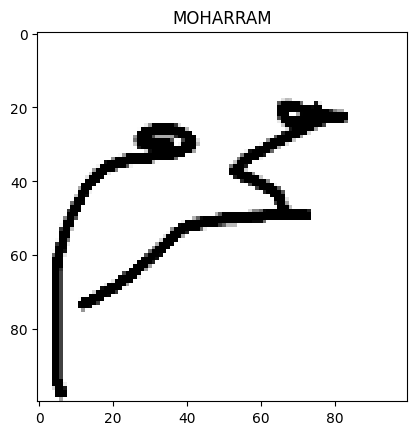

1/1 [==============================] - 0s 66ms/step
[array(['MORDAD', 'KHORDAD', 'FARVARDIN', 'FA_MAX', 'THOUSANDTH', 'FA_MIN',
       'JAMADI_OL_AVAL', 'FOURTEENTH', 'HEJRY', 'SHAVAL'], dtype='<U14')]


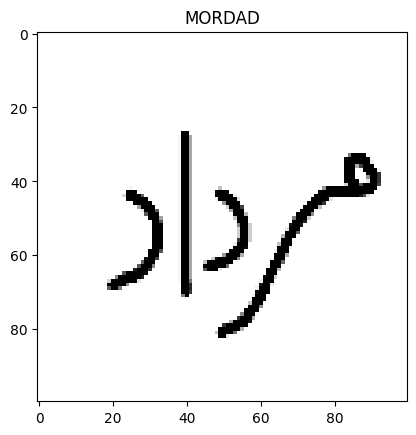

1/1 [==============================] - 0s 79ms/step
[array(['MYSELF', 'THOUSANDTH', 'THIRTIETH', 'ACOLYTE', 'FARVARDIN',
       'HOME', 'MOBILE', 'THIRTEENTH', 'KHORDAD', 'HEJRY'], dtype='<U14')]


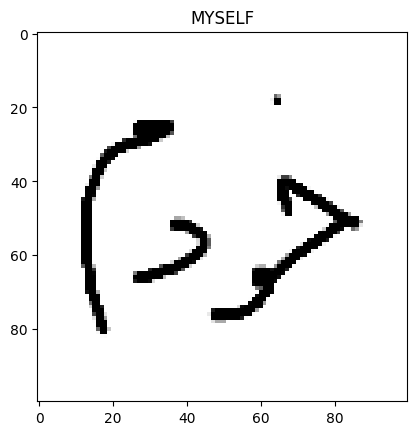

1/1 [==============================] - 0s 61ms/step
[array(['NINE', 'TIR', 'SEVEN', 'TEL', 'NINETY', 'EIGHTEEN', 'SIXTY',
       'THIRTEEN', 'NINTH', 'FIFTEENTH'], dtype='<U14')]


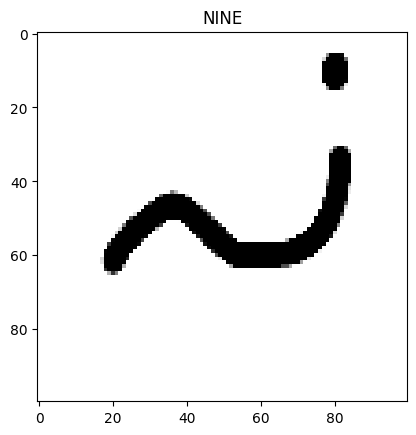

1/1 [==============================] - 0s 65ms/step
[array(['NINEHUNDRED', 'ONEHUNDRED', 'NINTH', 'SEVENHUNDRED', 'AUTOMOBILE',
       'SHAHRIVAR', 'TEL', 'INSTITUTION', 'THREEHUNDRED', 'ZERO'],
      dtype='<U14')]


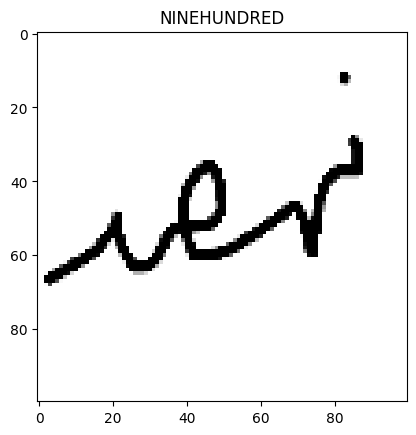

1/1 [==============================] - 0s 84ms/step
[array(['NINETEEN', 'FARVARDIN', 'NINETEENTH', 'THOUSANDTH', 'MYSELF',
       'SIXTEENTH', 'SHAHRIVAR', 'TWELVE', 'FOURTEEN', 'TWELFTH'],
      dtype='<U14')]


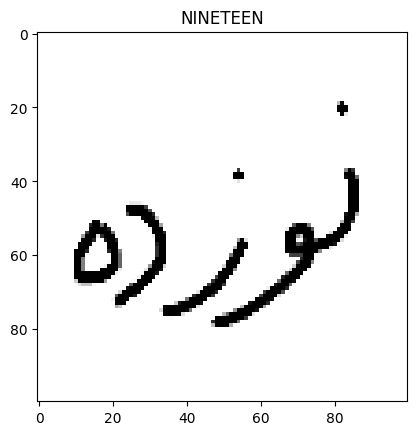

1/1 [==============================] - 0s 66ms/step
[array(['NINETEENTH', 'TWELFTH', 'FA_MAX', 'FARVARDIN', 'FA_MIN',
       'KHORDAD', 'AUTOMOBILE', 'ZEI_HAJJE', 'THIRTEENTH', 'FOURTEENTH'],
      dtype='<U14')]


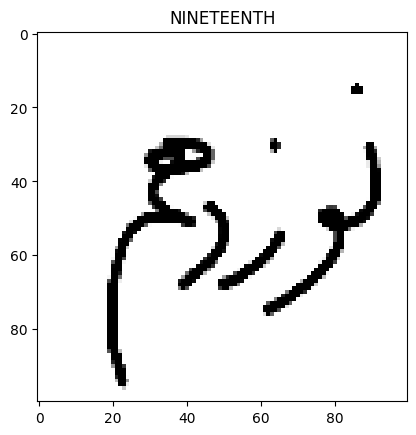

1/1 [==============================] - 0s 68ms/step
[array(['NINETY', 'FOURTEEN', 'THIRTEEN', 'FOUR', 'SHAHRIVAR', 'SHAVAL',
       'FOURTEENTH', 'NINETEEN', 'COMPUTER', 'TIR'], dtype='<U14')]


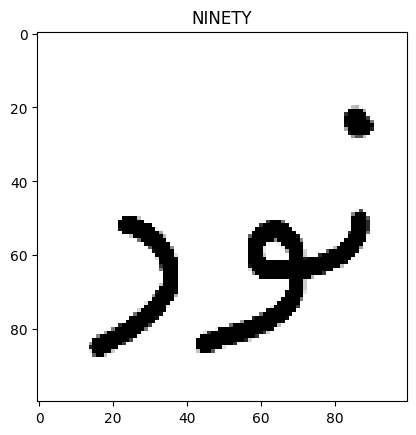

1/1 [==============================] - 0s 86ms/step
[array(['NINTH', 'FIFTEENTH', 'TEL', 'SIXTEENTH', 'MISTRESS',
       'SEVENTEENTH', 'FIFTH', 'END', 'KHORDAD', 'SEVENHUNDRED'],
      dtype='<U14')]


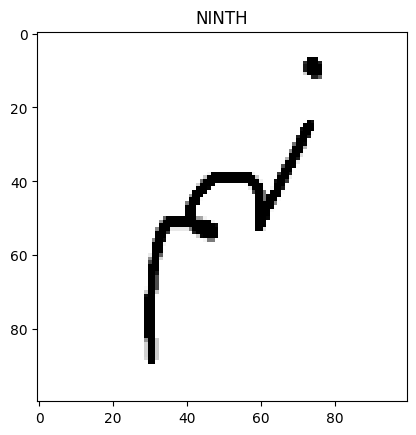

1/1 [==============================] - 0s 77ms/step
[array(['OFFICE', 'FARVARDIN', 'HEJRY', 'TWELVE', 'MOBILE', 'ORDIBEHESHT',
       'AUTOMOBILE', 'INITIAL', 'ZEI_HAJJE', 'INSTITUTION'], dtype='<U14')]


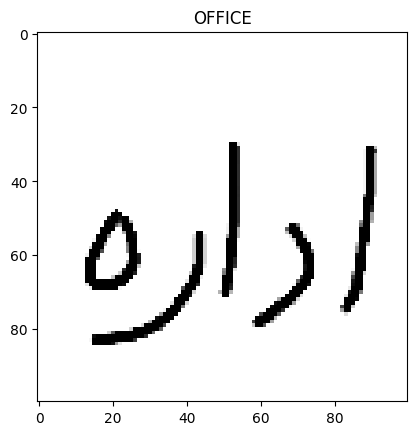

1/1 [==============================] - 0s 90ms/step
[array(['ONE', 'BANK', 'FIRST', 'CORPORATION', 'TIR', 'ONEHUNDRED',
       'FOURTY', 'RAJAB', 'NINE', 'MIN'], dtype='<U14')]


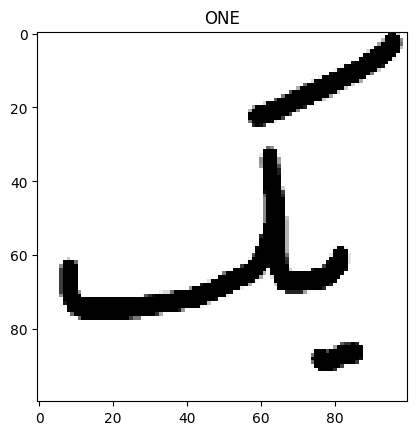

1/1 [==============================] - 0s 86ms/step
[array(['ONEMILLION', 'ONEHUNDRED', 'ONETHOUSAND', 'TIR', 'FIRST',
       'ONEMILLIARD', 'MILLION', 'FOURTH', 'ONE', 'FOUR'], dtype='<U14')]


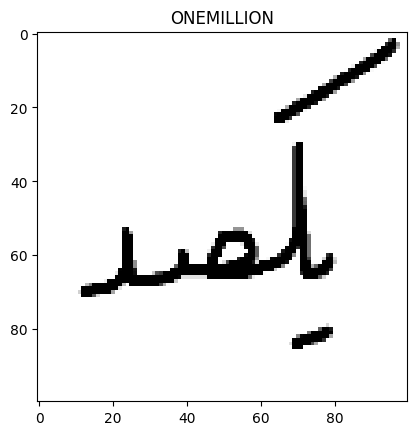

1/1 [==============================] - 0s 61ms/step
[array(['ONEMILLIARD', 'ONEMILLION', 'MILLIARD', 'FOURTEEN', 'FOURTH',
       'COMPUTER', 'EIGHTEEN', 'ONETHOUSAND', 'MILLION', 'FIFTY'],
      dtype='<U14')]


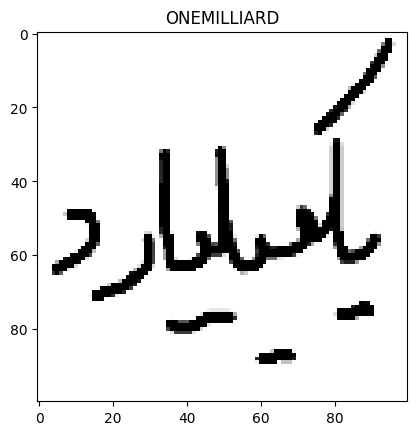

1/1 [==============================] - 0s 57ms/step
[array(['ONEMILLION', 'MILLION', 'ONEMILLIARD', 'MILLIARD', 'COMPUTER',
       'ONETHOUSAND', 'MIN', 'ORDIBEHESHT', 'FOURTH', 'FOURTEEN'],
      dtype='<U14')]


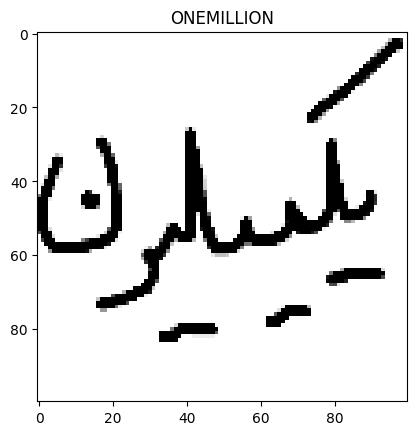

1/1 [==============================] - 0s 45ms/step
[array(['ONETHOUSAND', 'ONEMILLION', 'ONEMILLIARD', 'ONEHUNDRED',
       'SHAHRIVAR', 'MAX', 'COMPUTER', 'FA_MAX', 'SOLAR', 'FOURTH'],
      dtype='<U14')]


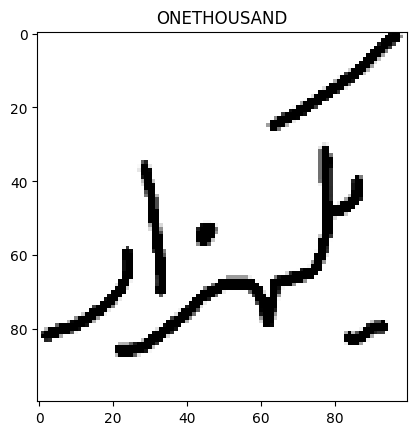

1/1 [==============================] - 0s 59ms/step
[array(['ORDIBEHESHT', 'FARVARDIN', 'OFFICE', 'AUTOMOBILE', 'FA_MAX',
       'COMPUTER', 'TWOHUNDRED', 'TWELVE', 'INSTITUTION', 'NINETEENTH'],
      dtype='<U14')]


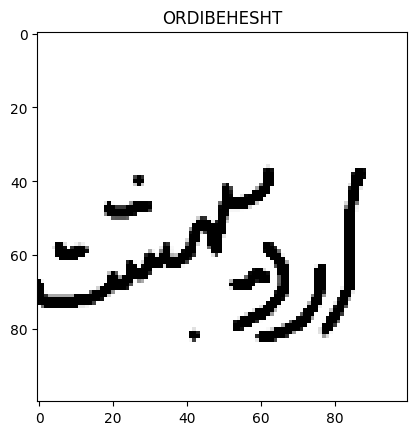

1/1 [==============================] - 0s 46ms/step
[array(['OVERSEER', 'MORDAD', 'MILLIARD', 'THOUSAND', 'KHORDAD',
       'THREEHUNDRED', 'FA_MIN', 'THIRTEEN', 'JAMADI_OL_AVAL', 'MILLION'],
      dtype='<U14')]


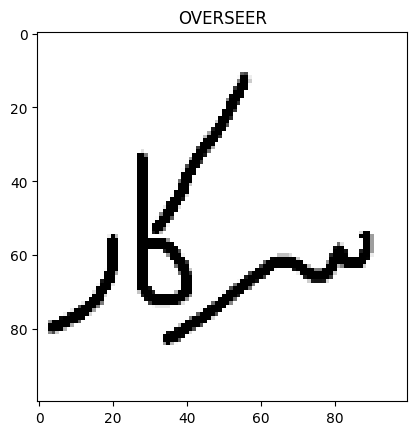

1/1 [==============================] - 0s 106ms/step
[array(['PURCHASE', 'MAX', 'FIFTH', 'SHAHRIVAR', 'EIGHTEEN', 'KHORDAD',
       'THOUSAND', 'AZAR', 'FIFTEEN', 'NINETY'], dtype='<U14')]


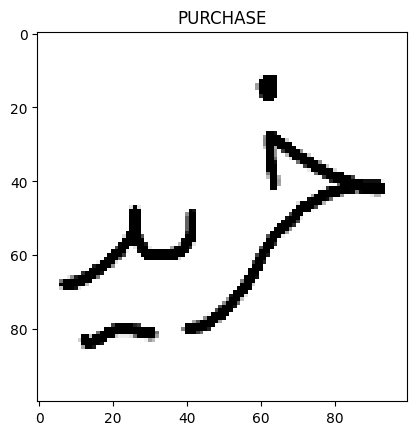

1/1 [==============================] - 0s 70ms/step
[array(['RABIE_O_AVAL', 'RABIE_O_SANI', 'JAMADI_OL_AVAL', 'MORDAD',
       'FOURTEEN', 'THIRTEEN', 'FOURTEENTH', 'FARVARDIN', 'MILLION',
       'KHORDAD'], dtype='<U14')]


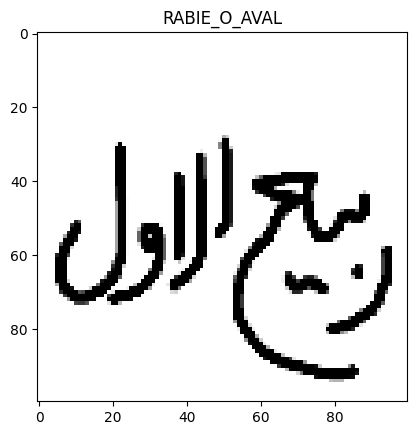

1/1 [==============================] - 0s 89ms/step
[array(['RABIE_O_SANI', 'SELVES', 'JAMADI_O_SANI', 'RAMEZAN',
       'RABIE_O_AVAL', 'FOURTH', 'FOUR', 'TOMAN', 'FA_MIN', 'FARVARDIN'],
      dtype='<U14')]


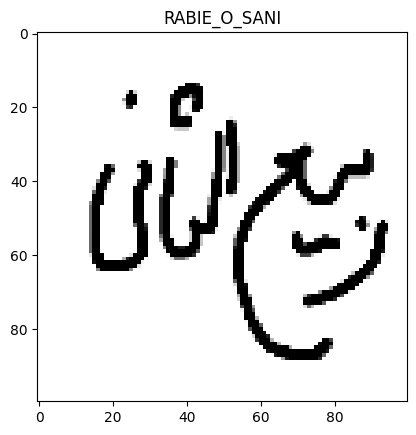

1/1 [==============================] - 0s 68ms/step
[array(['RAJAB', 'INSTITUTION', 'AUTOMOBILE', 'FARVARDIN', 'EIGHTEEN',
       'NINETEENTH', 'ZEI_HAJJE', 'TWOHUNDRED', 'OFFICE', 'ORDIBEHESHT'],
      dtype='<U14')]


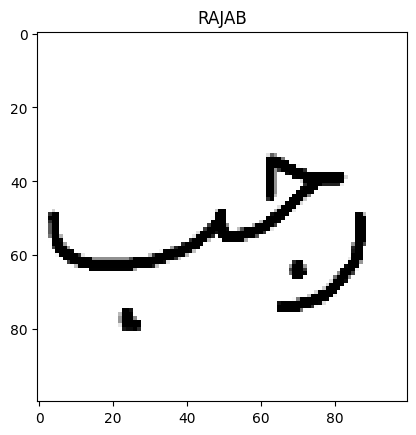

1/1 [==============================] - 0s 67ms/step
[array(['RAMEZAN', 'SELVES', 'FARVARDIN', 'ORDIBEHESHT', 'NINETEENTH',
       'RABIE_O_SANI', 'FIFTY', 'SEVEN', 'TOMAN', 'DEI'], dtype='<U14')]


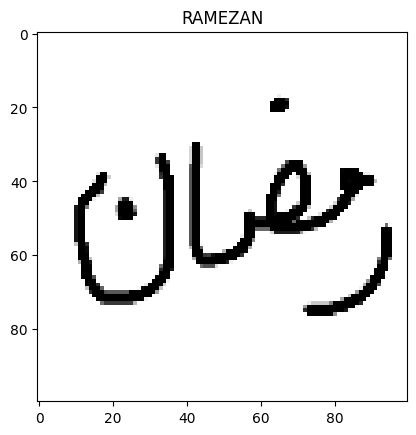

1/1 [==============================] - 0s 75ms/step
[array(['REGARD', 'TWENTIETH', 'BANK', 'FIVE', 'ELEVENTH', 'MIN',
       'FIVEHUNDRED', 'ELEVEN', 'COLLEGE', 'TEN'], dtype='<U14')]


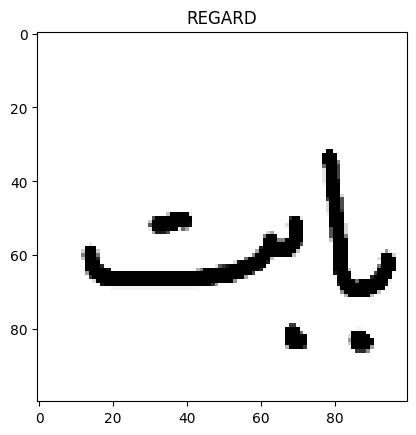

1/1 [==============================] - 0s 81ms/step
[array(['RIAL', 'FA_COMPUTER', 'FIFTY', 'INITIAL', 'THIRTIETH', 'MILLIARD',
       'EQUIVALENT', 'SHABAN', 'MILLION', 'ELEVEN'], dtype='<U14')]


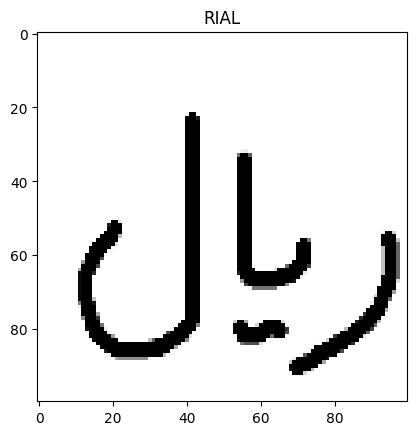

1/1 [==============================] - 0s 84ms/step
[array(['SECOND', 'FARVARDIN', 'RABIE_O_SANI', 'TOMAN', 'NINETEENTH',
       'FA_MAX', 'FA_MIN', 'JAMADI_O_SANI', 'DEI', 'INITIAL'],
      dtype='<U14')]


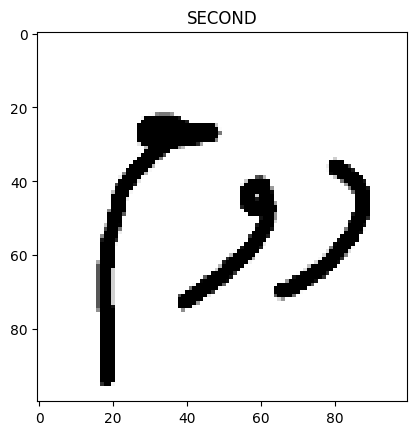

1/1 [==============================] - 0s 95ms/step
[array(['SELVES', 'AUTOMOBILE', 'TOMAN', 'FARVARDIN', 'NINETEENTH',
       'FA_MIN', 'NINETEEN', 'MOBILE', 'RABIE_O_SANI', 'INSTITUTION'],
      dtype='<U14')]


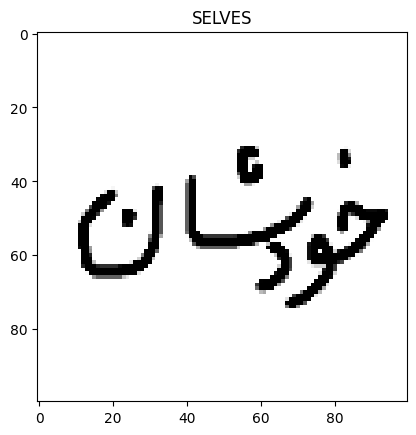

1/1 [==============================] - 0s 90ms/step
[array(['SEVENTH', 'EIGHTH', 'RAMEZAN', 'SEVENTEENTH', 'SEVEN', 'ZERO',
       'SEVENTEEN', 'TEL', 'GENTLEMAN', 'HUNDREDTH'], dtype='<U14')]


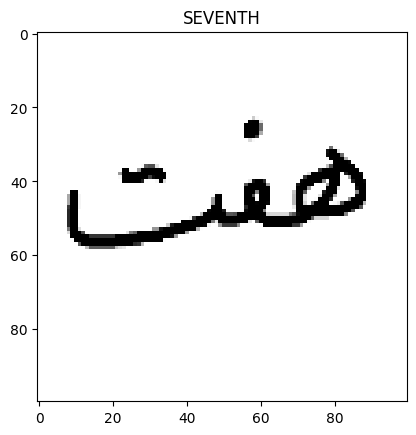

1/1 [==============================] - 0s 65ms/step
[array(['SEVENHUNDRED', 'EIGHTH', 'GENTLEMAN', 'EIGHTHUNDRED',
       'SEVENTEENTH', 'SEVENTH', 'EIGHT', 'ZERO', 'SEVEN', 'EIGHTY'],
      dtype='<U14')]


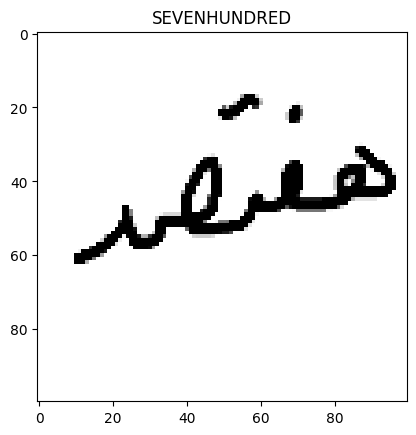

1/1 [==============================] - 0s 79ms/step
[array(['SEVENTH', 'EIGHTH', 'FOUR', 'SEVENTEEN', 'SEVENTEENTH',
       'EIGHTEEN', 'EIGHTEENTH', 'THOUSANDTH', 'FOURTH', 'FIFTEEN'],
      dtype='<U14')]


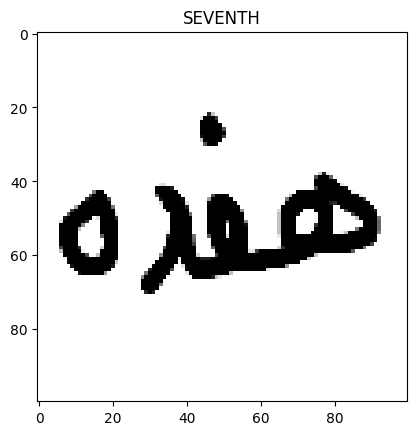

1/1 [==============================] - 0s 79ms/step
[array(['SEVENTEENTH', 'NINETEENTH', 'TWELFTH', 'NINTH', 'SECOND',
       'GENTLEMAN', 'SIXTEENTH', 'FIFTEENTH', 'EIGHTEENTH', 'RAMEZAN'],
      dtype='<U14')]


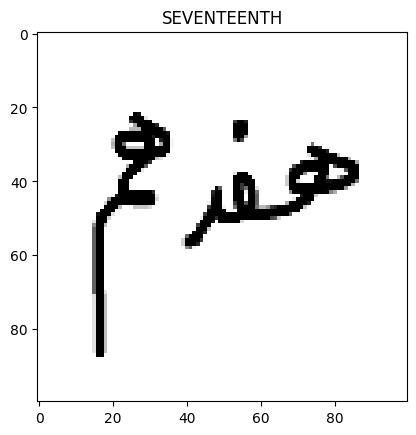

1/1 [==============================] - 0s 66ms/step
[array(['SEVENTEENTH', 'SEVENTH', 'EIGHTH', 'SEVEN', 'SEVENTEEN',
       'RAMEZAN', 'NINTH', 'SEVENHUNDRED', 'GENTLEMAN', 'ZERO'],
      dtype='<U14')]


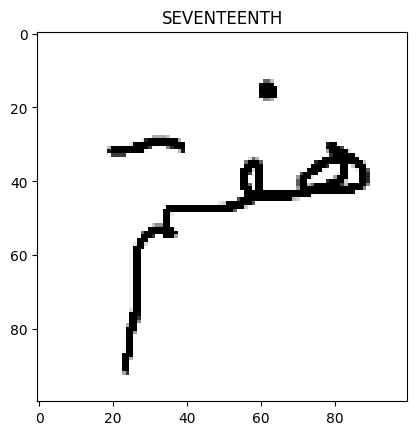

1/1 [==============================] - 0s 59ms/step
[array(['SEVENTY', 'KHORDAD', 'EIGHTY', 'ONETHOUSAND', 'SELVES', 'FA_MAX',
       'SEVENHUNDRED', 'NINETEEN', 'NINEHUNDRED', 'SEVENTEEN'],
      dtype='<U14')]


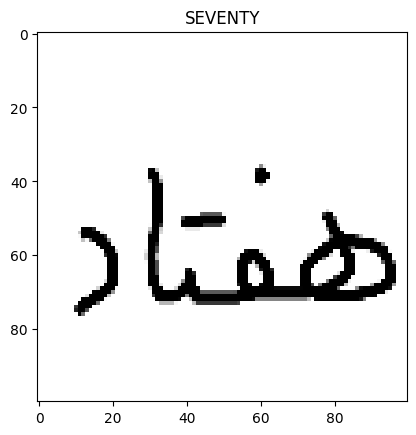

1/1 [==============================] - 0s 83ms/step
[array(['SHABAN', 'FIFTY', 'RABIE_O_SANI', 'THIRTIETH', 'AUTOMOBILE',
       'EIGHTEEN', 'RAMEZAN', 'FOURTY', 'FARVARDIN', 'FOURTH'],
      dtype='<U14')]


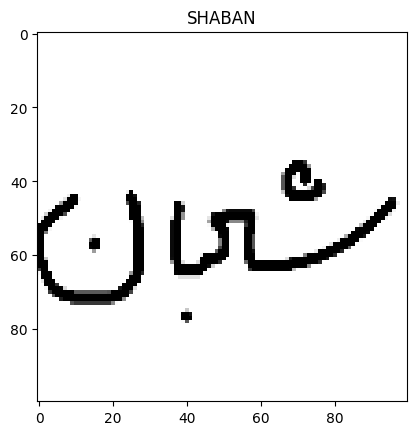

1/1 [==============================] - 0s 50ms/step
[array(['SHAHRIVAR', 'PURCHASE', 'EIGHTEEN', 'KHORDAD', 'SIXTEENTH',
       'COMPUTER', 'FOURHUNDRED', 'FOURTEENTH', 'SOLAR', 'SIXTEEN'],
      dtype='<U14')]


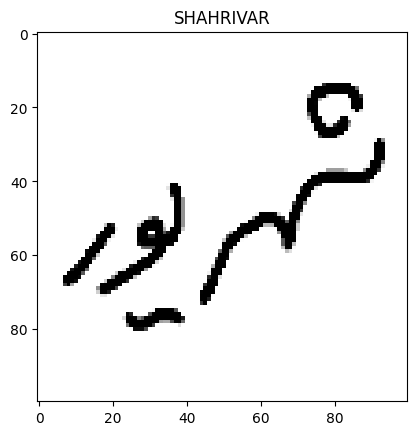

1/1 [==============================] - 0s 73ms/step
[array(['SHAVAL', 'SHABAN', 'FARVARDIN', 'EQUIVALENT', 'BAHMAN', 'INITIAL',
       'FA_MIN', 'HEJRY', 'FIVE', 'BEARER'], dtype='<U14')]


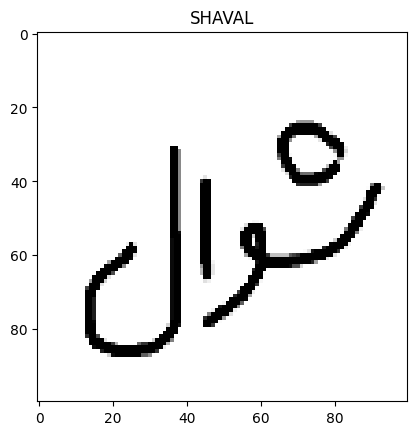

1/1 [==============================] - 0s 70ms/step
[array(['AZAR', 'OVERSEER', 'COLLEGE', 'ABAN', 'END', 'SIR', 'BANK',
       'EIGHTY', 'FOUR', 'TEL'], dtype='<U14')]


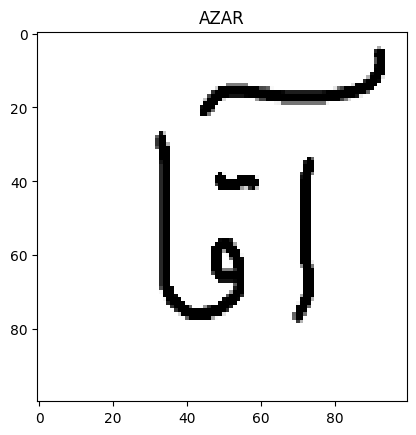

1/1 [==============================] - 0s 86ms/step
[array(['SIX', 'SIXTH', 'MOHARRAM', 'EIGHT', 'BAHMAN', 'HOME', 'TEN',
       'TWENTY', 'EIGHTH', 'MACHINE'], dtype='<U14')]


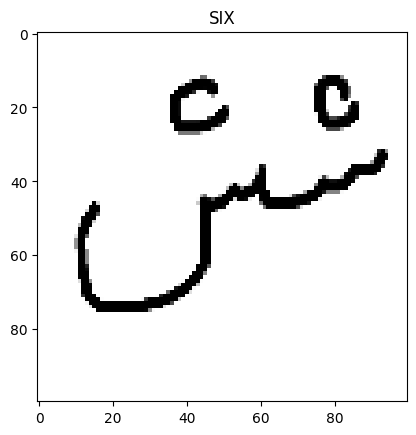

1/1 [==============================] - 0s 69ms/step
[array(['SIXTEEN', 'SHAHRIVAR', 'SEVENHUNDRED', 'SIXTH', 'SIXTEENTH',
       'TEL', 'EIGHTEEN', 'SIXHUNDRED', 'EIGHTHUNDRED', 'EIGHTH'],
      dtype='<U14')]


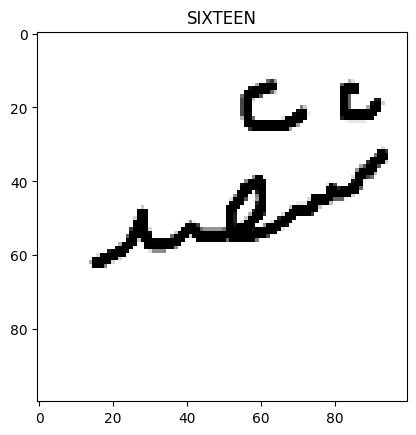

1/1 [==============================] - 0s 100ms/step
[array(['SIXTEENTH', 'THIRTEEN', 'SIXTEEN', 'FIFTEENTH', 'THIRTIETH',
       'SHABAN', 'MYSELF', 'ELEVEN', 'THIRTEENTH', 'MISTRESS'],
      dtype='<U14')]


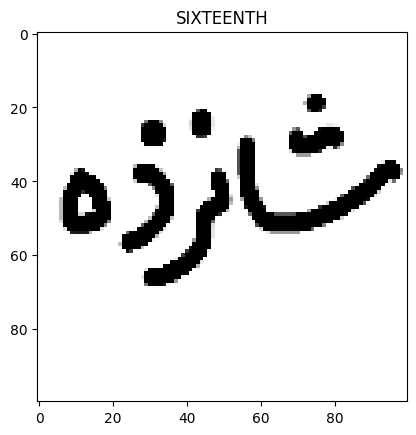

1/1 [==============================] - 0s 74ms/step
[array(['SIXTEENTH', 'MAX', 'FOURTEENTH', 'ELEVENTH', 'FOURTH',
       'THOUSANDTH', 'TWELFTH', 'MISTRESS', 'MOHARRAM', 'FIFTEENTH'],
      dtype='<U14')]


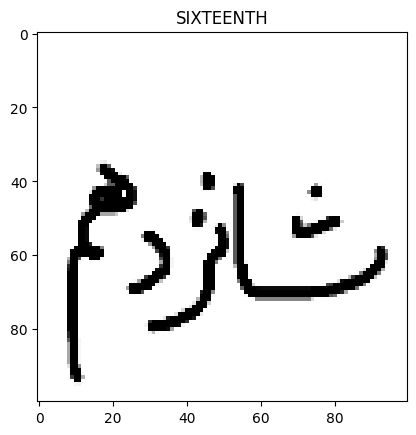

1/1 [==============================] - 0s 61ms/step
[array(['SIXTH', 'NINTH', 'SECOND', 'MYSELF', 'SIXTEENTH', 'THIRTIETH',
       'MISTRESS', 'TENTH', 'FIRST', 'GENTLEMAN'], dtype='<U14')]


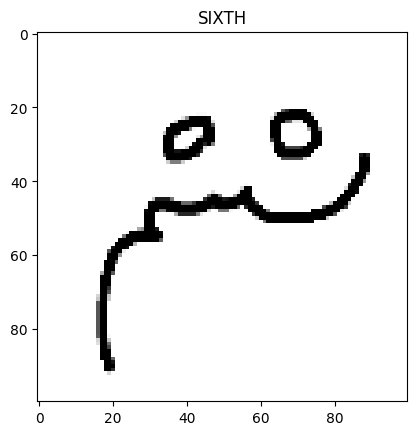

1/1 [==============================] - 0s 65ms/step
[array(['SIXTY', 'FARVARDIN', 'SEVEN', 'BAHMAN', 'NINTH', 'EIGHTH',
       'SHAHRIVAR', 'MYSELF', 'FOURTEENTH', 'INSTITUTION'], dtype='<U14')]


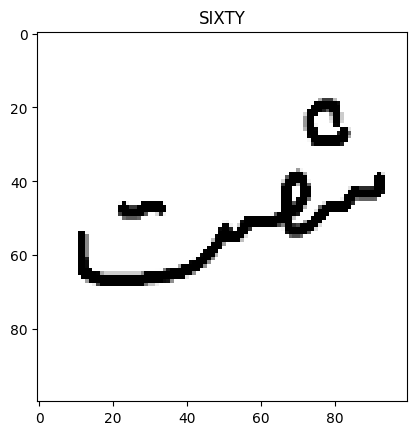

1/1 [==============================] - 0s 74ms/step
[array(['SOLAR', 'SIXTY', 'FIVE', 'SHAHRIVAR', 'SIX', 'NINE', 'MOHARRAM',
       'SHABAN', 'ACOLYTE', 'DEI'], dtype='<U14')]


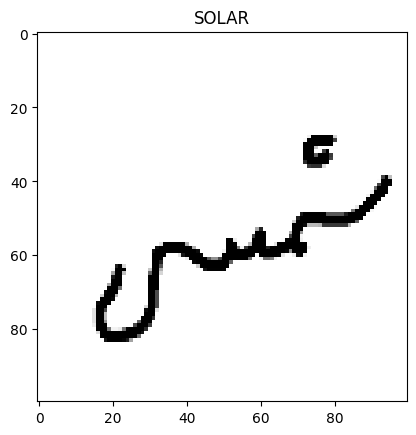

1/1 [==============================] - 0s 65ms/step
[array(['COMPUTER', 'TEL', 'BAHMAN', 'MACHINE', 'FARVARDIN', 'MAX',
       'SIXTEENTH', 'THIRTEEN', 'SHAHRIVAR', 'GENTLEMAN'], dtype='<U14')]


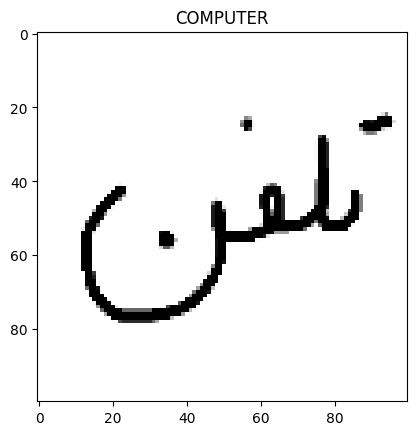

1/1 [==============================] - 0s 69ms/step
[array(['TEN', 'FOURTH', 'FIVE', 'FOURTY', 'DEI', 'END', 'FOURTEENTH',
       'MISTRESS', 'FOURTEEN', 'EIGHTEEN'], dtype='<U14')]


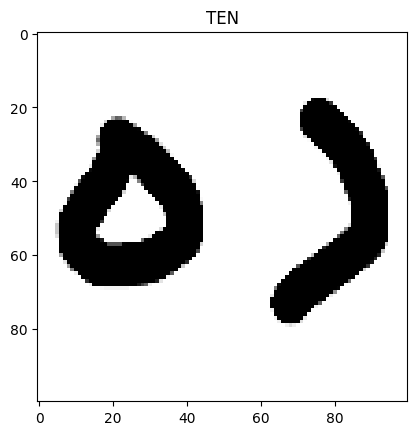

1/1 [==============================] - 0s 79ms/step
[array(['NINETEENTH', 'RAJAB', 'ZEI_HAJJE', 'ELEVENTH', 'TWELFTH', 'TENTH',
       'ONE', 'ELEVEN', 'BANK', 'COLLEGE'], dtype='<U14')]


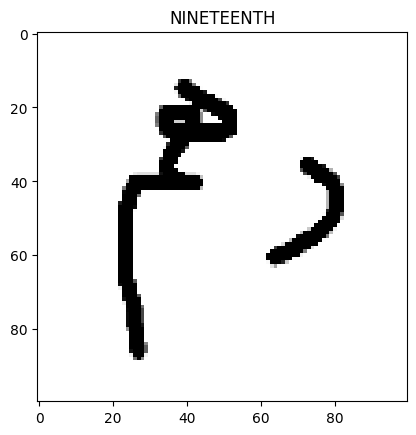

1/1 [==============================] - 0s 74ms/step
[array(['THIRD', 'THIRTEENTH', 'MYSELF', 'HUNDREDTH', 'THIRTIETH',
       'GENTLEMAN', 'MORDAD', 'THIRTEEN', 'THIRTY', 'ZERO'], dtype='<U14')]


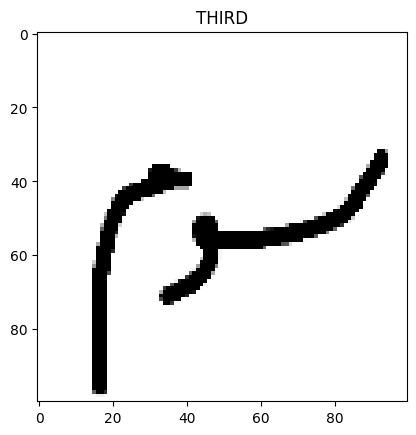

1/1 [==============================] - 0s 70ms/step
[array(['THIRTEENTH', 'THIRTEEN', 'FOURTEENTH', 'RABIE_O_AVAL', 'ELEVEN',
       'MILLIARD', 'RABIE_O_SANI', 'KHORDAD', 'FOURHUNDRED', 'MILLION'],
      dtype='<U14')]


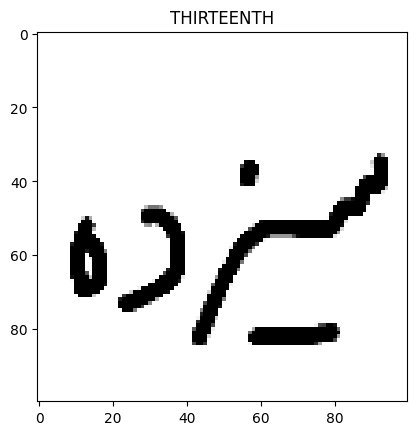

1/1 [==============================] - 0s 75ms/step
[array(['THIRTEENTH', 'THIRD', 'FOURTEENTH', 'THIRTIETH', 'MOHARRAM',
       'HUNDREDTH', 'EIGHTEENTH', 'FOURTH', 'TWENTIETH', 'MYSELF'],
      dtype='<U14')]


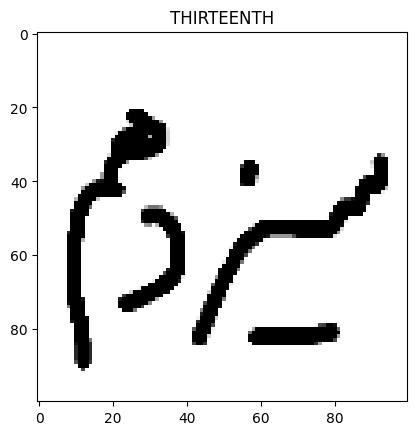

1/1 [==============================] - 0s 63ms/step
[array(['THIRTIETH', 'THIRTEENTH', 'RABIE_O_SANI', 'THOUSANDTH',
       'THIRTEEN', 'MYSELF', 'MILLIARD', 'EQUIVALENT', 'FARVARDIN',
       'MORDAD'], dtype='<U14')]


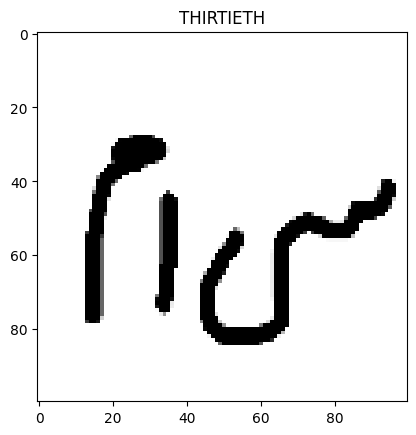

1/1 [==============================] - 0s 69ms/step
[array(['THIRTY', 'EQUIVALENT', 'MOHARRAM', 'THIRTIETH', 'MEHR', 'NINTH',
       'BAHMAN', 'HEJRY', 'THIRTEEN', 'DEI'], dtype='<U14')]


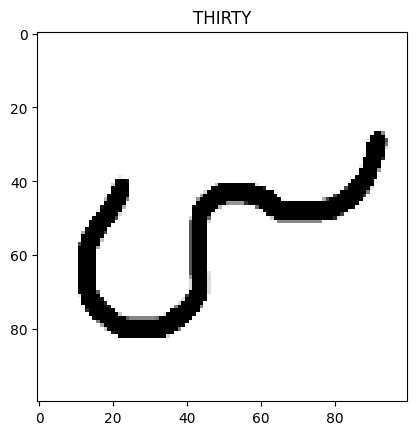

1/1 [==============================] - 0s 80ms/step
[array(['THOUSANDTH', 'THOUSAND', 'TWELVE', 'FOURTEEN', 'NINETEEN',
       'FA_MAX', 'MYSELF', 'FARVARDIN', 'KHORDAD', 'HEJRY'], dtype='<U14')]


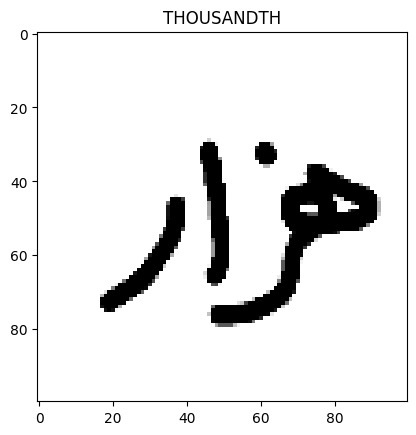

1/1 [==============================] - 0s 77ms/step
[array(['THOUSANDTH', 'FOURTH', 'MYSELF', 'GENTLEMAN', 'TWELVE',
       'MOHARRAM', 'HEJRY', 'FOURTEENTH', 'TWELFTH', 'THOUSAND'],
      dtype='<U14')]


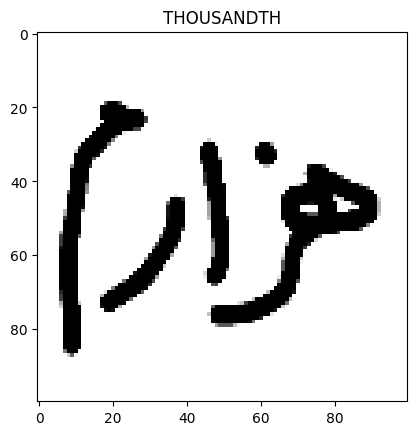

1/1 [==============================] - 0s 75ms/step
[array(['THREE', 'EIGHTEEN', 'TIR', 'NINE', 'THIRD', 'HUNDRED', 'TEN',
       'ONE', 'THIRTY', 'PURCHASE'], dtype='<U14')]


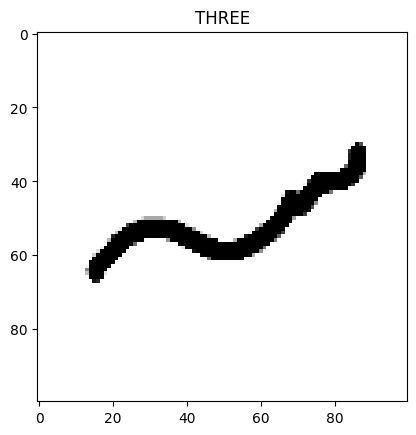

1/1 [==============================] - 0s 94ms/step
[array(['THREEHUNDRED', 'FIVEHUNDRED', 'MIN', 'ONEHUNDRED', 'FOURHUNDRED',
       'FIFTH', 'PURCHASE', 'TWENTIETH', 'FOUR', 'THIRD'], dtype='<U14')]


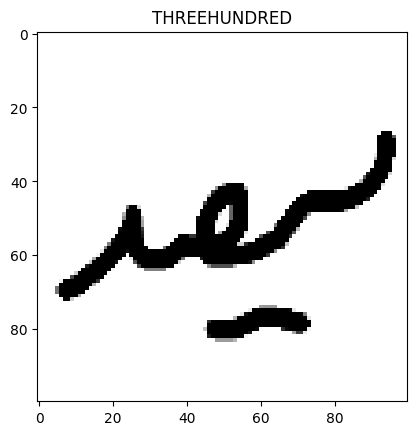

1/1 [==============================] - 0s 68ms/step
[array(['TIR', 'ACOLYTE', 'THIRTEEN', 'SHAHRIVAR', 'FOUR', 'HEJRY',
       'SOLAR', 'DEI', 'FOURTY', 'TOMAN'], dtype='<U14')]


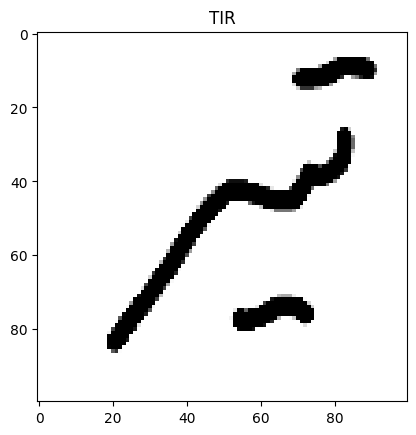

1/1 [==============================] - 0s 73ms/step
[array(['TOMAN', 'FARVARDIN', 'AUTOMOBILE', 'FIFTY', 'INITIAL', 'THIRTEEN',
       'NINETEEN', 'FOURTEEN', 'RAMEZAN', 'SHABAN'], dtype='<U14')]


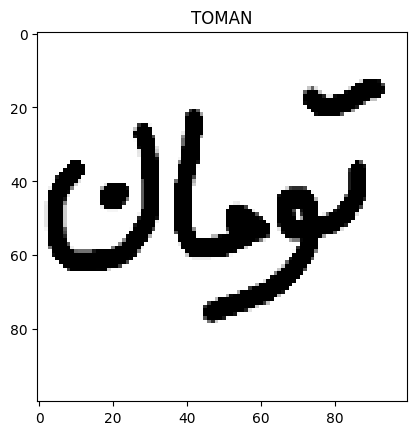

1/1 [==============================] - 0s 58ms/step
[array(['TWELFTH', 'NINETEENTH', 'SECOND', 'FARVARDIN', 'TWELVE',
       'THOUSANDTH', 'FOURTEENTH', 'ELEVENTH', 'FIFTEENTH', 'SIXTEENTH'],
      dtype='<U14')]


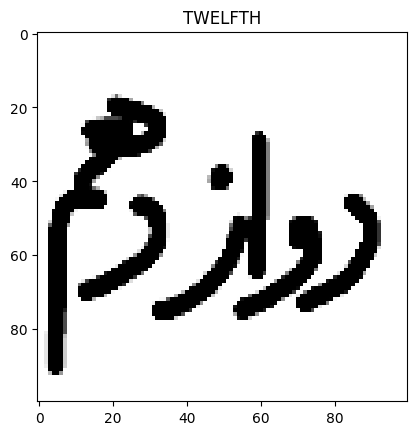

1/1 [==============================] - 0s 76ms/step
[array(['TWELVE', 'FARVARDIN', 'NINETEEN', 'TWELFTH', 'FOURTEEN', 'OFFICE',
       'NINETY', 'FIFTEEN', 'TWOHUNDRED', 'INSTITUTION'], dtype='<U14')]


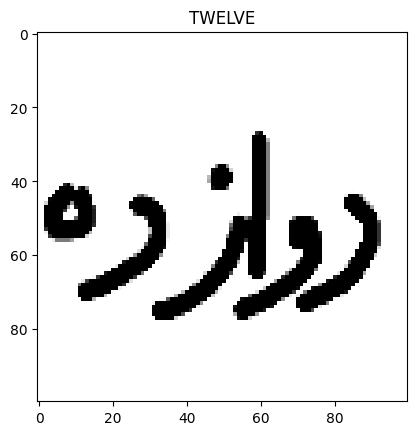

1/1 [==============================] - 0s 92ms/step
[array(['TWENTIETH', 'EIGHTH', 'FIFTH', 'HUNDREDTH', 'RABIE_O_SANI',
       'SEVENTH', 'FOURTH', 'MIN', 'THIRD', 'FOURTEENTH'], dtype='<U14')]


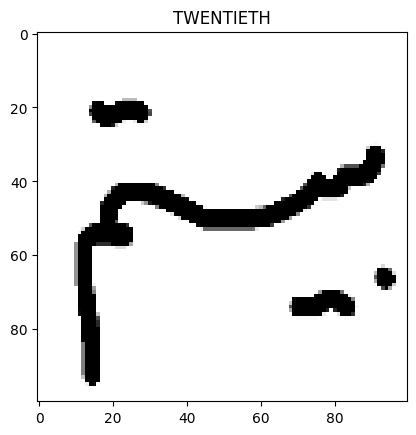

1/1 [==============================] - 0s 83ms/step
[array(['TWENTY', 'CORPORATION', 'TWENTIETH', 'MIN', 'ONE', 'FOURTY',
       'SIXTY', 'DEI', 'BAHMAN', 'RABIE_O_SANI'], dtype='<U14')]


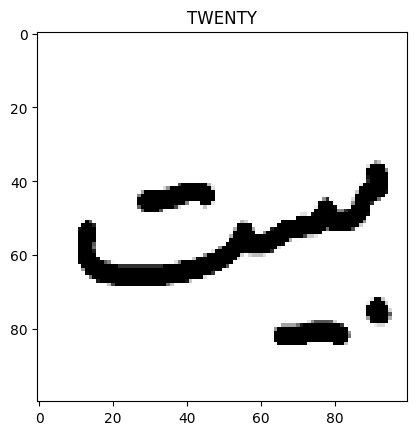

1/1 [==============================] - 0s 92ms/step
[array(['NINETY', 'THIRTEEN', 'TWO', 'MORDAD', 'KHORDAD', 'FA_MAX',
       'SHAHRIVAR', 'OFFICE', 'OVERSEER', 'RAJAB'], dtype='<U14')]


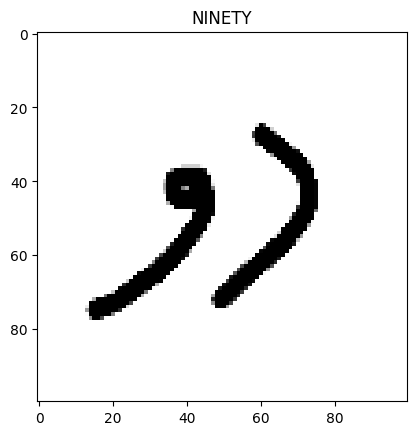

1/1 [==============================] - 0s 58ms/step
[array(['TWOHUNDRED', 'AUTOMOBILE', 'MOBILE', 'FARVARDIN', 'ORDIBEHESHT',
       'REGARD', 'HEJRY', 'RAJAB', 'MACHINE', 'DEI'], dtype='<U14')]


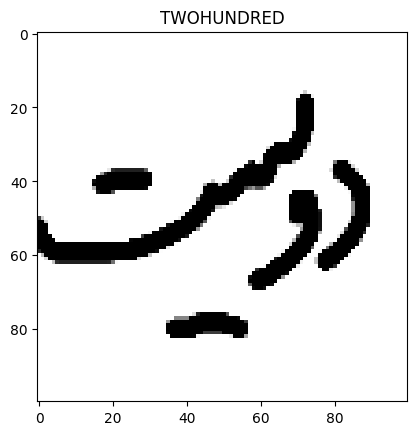

1/1 [==============================] - 0s 71ms/step
[array(['ZEI_GHADE', 'ZEI_HAJJE', 'MACHINE', 'MAX', 'FOURHUNDRED',
       'FIVEHUNDRED', 'SIXTEENTH', 'SIXTEEN', 'JAMADI_OL_AVAL',
       'THIRTEEN'], dtype='<U14')]


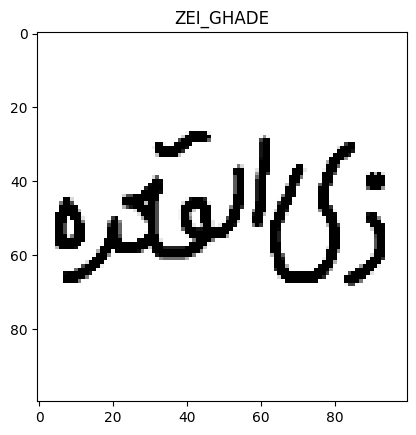

1/1 [==============================] - 0s 121ms/step
[array(['ZEI_HAJJE', 'FOURHUNDRED', 'MAX', 'FOURTEENTH', 'JAMADI_OL_AVAL',
       'ONEHUNDRED', 'EIGHTEEN', 'BEARER', 'SIXTEENTH', 'FIFTH'],
      dtype='<U14')]


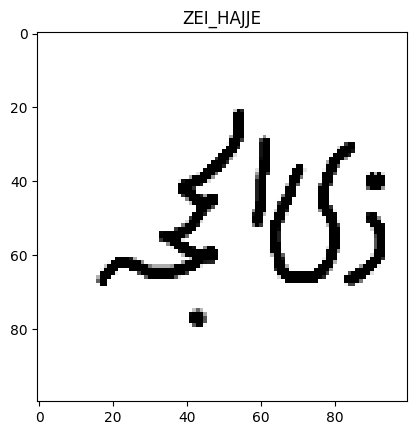

1/1 [==============================] - 0s 79ms/step
[array(['ZERO', 'SEVENTH', 'SEVEN', 'THOUSAND', 'SEVENTEEN', 'TEL',
       'SEVENTEENTH', 'THIRTEEN', 'BAHMAN', 'NINETY'], dtype='<U14')]


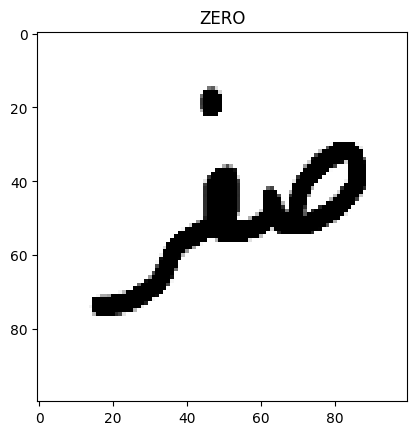

In [ ]:
for filename in os.listdir("test_dataset"):
    predicted_label = predict_label(os.path.join("test_dataset",filename))